<a href="https://colab.research.google.com/github/anhpdd/ml-property-valuation-klang-valley/blob/main/notebooks/5_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset

In [2]:
# Installation
!pip install xgboost lightgbm geopandas openpyxl

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pickle # Export models
import json
from datetime import datetime
from google.colab import files
import os

# Scikit-learn - Model Selection & Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn - Metrics
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error
)

# Scikit-learn - Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Advanced ML Models
import xgboost as xgb
import lightgbm as lgb

# Utilities
import joblib

# Settings
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (12, 6)

# Set display options for better readability
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

%matplotlib inline

# Colors
COLORS = {
    'blue': '#174A7E',
    'orange': '#FAA43A',
    'red': '#F15854',
    'grey': '#808080',
    'green': '#2ECC71'
}

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Import the dataset
df_raw = pd.read_excel('/content/drive/MyDrive/Colab/Capstone 1/clustered.xlsx')
print(df_raw.shape)
df_raw.head()

(68677, 46)


Unnamed: 0  records_id                   property_type     district  \
0           0           9  1 - 1 1/2 storey semi-detached       gombak   
1           1          15  1 - 1 1/2 storey semi-detached       gombak   
2           2          16  1 - 1 1/2 storey semi-detached       gombak   
3           3          31  1 - 1 1/2 storey semi-detached  hulu langat   
4           4          32  1 - 1 1/2 storey semi-detached  hulu langat   

             mukim             scheme_name         road_name       date  \
0  bandar selayang  taman selayang mutiara  jalan mutiara 3a 2023-08-01   
1  bandar selayang  taman selayang mutiara   jalan mutiara 5 2023-03-01   
2  bandar selayang  taman selayang mutiara   jalan mutiara 5 2023-06-01   
3           ampang         kg pandan dalam    lorong laman 4 2023-11-01   
4           ampang         kg pandan dalam         lorong d2 2023-07-01   

   land_m2  property_m2  transaction_price  year  unit_level      way_id  \
0   287.00        96.00             530000  2023           0   227276649   
1   205.00        74.00             440000  2023           0  1154648616   
2   220.00        74.00             450000  2023           0  1154648616   
3   261.05       149.00             430000  2023           0    39921369   
4   262.91        91.00             440000  2023           0   170831448   

                                            geometry  freehold  price_m2  \
0  LINESTRING (101.7205048 3.2367576, 101.721861 ...         0   5520.83   
1  LINESTRING (101.7217013 3.2373064, 101.7204728...         0   5945.95   
2  LINESTRING (101.7217013 3.2373064, 101.7204728...         0   6081.08   
3  LINESTRING (101.7457987 3.1436177, 101.7476206...         0   2885.91   
4  LINESTRING (101.7476206 3.1436134, 101.7501103...         0   4835.16   

   mall_count  school_count  park_count  river_count  lake_count  \
0           1             4           0            2           0   
1           1             4           0            3           0   
2           1             4           0            3           0   
3          12             8           6            0           1   
4          13             5           5            0           0   

   rail_station_count                           train_ids  \
0                   1                           243237659   
1                   1                           243237659   
2                   1                           243237659   
3                   2              9704514040, 9704514037   
4                   3  9704514044, 9704514040, 9704514037   

   incoming_ridership_within_1km  outgoing_ridership_within_1km  \
0                         120923                         115916   
1                         125288                         123994   
2                         112017                         110963   
3                         188227                         156028   
4                         253502                         215572   

   total_ridership_within_1km  walk_dist_to_mall  walk_dist_to_school  \
0                      236839               2.85                 1.08   
1                      249282               2.64                 0.52   
2                      222980               2.64                 0.52   
3                      344255               0.41                 0.56   
4                      469074               0.50                 0.52   

   walk_dist_to_park  walk_dist_to_river  walk_dist_to_lake  \
0               3.16                2.29               3.79   
1               3.03                1.74               3.24   
2               3.03                1.74               3.24   
3               0.49                3.12               5.43   
4               1.12                2.86               5.16   

   walk_dist_to_rail_station  dist_to_mall  dist_to_school  dist_to_park  \
0                       3.80          2.89            0.93          3.02   
1                       3.67          2.80  

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68677 entries, 0 to 68676
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     68677 non-null  int64         
 1   records_id                     68677 non-null  int64         
 2   property_type                  68677 non-null  object        
 3   district                       68677 non-null  object        
 4   mukim                          68677 non-null  object        
 5   scheme_name                    68677 non-null  object        
 6   road_name                      68677 non-null  object        
 7   date                           68677 non-null  datetime64[ns]
 8   land_m2                        68677 non-null  float64       
 9   property_m2                    68677 non-null  float64       
 10  transaction_price              68677 non-null  int64         
 11  year           

# Data Cleaning

In [5]:
# The old price_m2 was calculated based on property_m2, which can be biased
df_raw.drop(columns='price_m2', inplace = True)

# Recalculate on land_m2 instead
df_raw['price_m2'] = df_raw['transaction_price'] / df_raw['land_m2']

# Convert -1 (LG) unit_level to 0 (G)
df_raw.loc[df_raw['unit_level'] < 0, 'unit_level'] = 0

# Consolidated column dropping
columns_to_drop = [
    'records_id', 'geometry', 'x_coord', 'y_coord', 'way_id', 'train_ids', 'Unnamed: 0', # Redundant ids or geographically coordinates.
    'date', # Extract year from date already
    'mukim', 'road_name', 'scheme_name',  # market_cluster_id will represent this location identifiers
    'market_cluster', 'clustering_method', 'is_noise', # Redundant cluster information
    'transaction_price', 'land_m2', # Remove due to new price_m2 creation
    'total_ridership_within_1km' # Redundant ridership information
]

# Drop consodilated columns
df_clean = df_raw.drop(columns=columns_to_drop)

print(f"DataFrame shape before: {df_raw.shape}")

print(f"DataFrame head after: {df_clean.shape}")
print("-" * 50)
print(df_clean.head())
print("-" * 50)

DataFrame shape before: (68677, 46)
DataFrame head after: (68677, 29)
--------------------------------------------------
                    property_type     district  property_m2  year  unit_level  \
0  1 - 1 1/2 storey semi-detached       gombak        96.00  2023           0   
1  1 - 1 1/2 storey semi-detached       gombak        74.00  2023           0   
2  1 - 1 1/2 storey semi-detached       gombak        74.00  2023           0   
3  1 - 1 1/2 storey semi-detached  hulu langat       149.00  2023           0   
4  1 - 1 1/2 storey semi-detached  hulu langat        91.00  2023           0   

   freehold  mall_count  school_count  park_count  river_count  lake_count  \
0         0           1             4           0            2           0   
1         0           1             4           0            3           0   
2         0           1             4           0            3           0   
3         0          12             8           6            0           1   
4 

In [6]:
# Fill missing values in distance columns with maximum distance
dist_cols = df_clean.columns[df_clean.columns.str.contains("dist_")]

print("Missing values in distance columns before filled with maximum distance:")
print("-" * 50)
display(df_clean[dist_cols].isnull().sum())


for col in dist_cols:
    district_max_dist = df_clean.groupby('district')[col].transform('max') # Cap distance at max in its distance
    df_clean[col] = df_clean[col].fillna(district_max_dist).fillna(21)     # Otherwise, capped at 21 km (since most maxxed at 20km)
    df_clean[col] = round(df_clean[col], 3)


print("Missing values in distance columns after filled with maximum distance:")
print("-" * 50)
display(df_clean[dist_cols].isnull().sum())
print("-" * 50)

Missing values in distance columns before filled with maximum distance:
--------------------------------------------------


walk_dist_to_mall                0
walk_dist_to_school              0
walk_dist_to_park                0
walk_dist_to_river             448
walk_dist_to_lake                0
walk_dist_to_rail_station     8957
dist_to_mall                  1190
dist_to_school                1173
dist_to_park                  1119
dist_to_river                 1641
dist_to_lake                  1371
dist_to_rail_station         10269
dtype: int64

Missing values in distance columns after filled with maximum distance:
--------------------------------------------------


walk_dist_to_mall            0
walk_dist_to_school          0
walk_dist_to_park            0
walk_dist_to_river           0
walk_dist_to_lake            0
walk_dist_to_rail_station    0
dist_to_mall                 0
dist_to_school               0
dist_to_park                 0
dist_to_river                0
dist_to_lake                 0
dist_to_rail_station         0
dtype: int64

--------------------------------------------------


#EDA

## Summary stats by district

In [7]:
# Summary statistics by district for transit
print(df_clean.shape)
for district in df_clean['district'].unique():
    print(f"\n{district.upper()}")
    print("-"*70)
    display(df_clean[df_clean['district'] == district].describe())

(68677, 29)

GOMBAK
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count      5873.00 5873.00     5873.00   5873.00     5873.00       5873.00   
mean        115.53 2023.46        1.94      0.47        2.97          2.86   
std          68.30    0.55        4.05      0.50        2.87          2.69   
min           5.10 2023.00        0.00      0.00        0.00          0.00   
25%          75.00 2023.00        0.00      0.00        1.00          1.00   
50%          98.00 2023.00        0.00      0.00        2.00          2.00   
75%         133.00 2024.00        2.00      1.00        4.00          4.00   
max        1021.00 2025.00       36.00      1.00       16.00         18.00   

       park_count  river_count  lake_count  rail_station_count  \
count     5873.00      5873.00     5873.00             5873.00   
mean         2.82         3.74        0.41                0.08   
std          3.07         4.66        0.65                0.33   
min          0.00         0.00        0.00                0.00   
25%          0.00         1.00        0.00                0.00   
50%          2.00         2.00        0.00                0.00   
75%          5.00         6.00        1.00                0.00   
max         15.00        29.00        5.00                3.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                        5873.00                        5873.00   
mean                         5368.71                        6079.65   
std                         29478.03                       28486.25   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                        298757.00                      301919.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count            5873.00              5873.00            5873.00   
mean                1.18                 1.54               1.41   
std                 0.96                 1.14               1.05   
min                 0.00                 0.00               0.00   
25%                 0.49                 0.70               0.65   
50%                 0.92                 1.15               1.15   
75%                 1.66                 2.11               2.05   
max                 5.90                 5.94               5.75   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count             5873.00            5873.00                    5873.00   
mean                 1.87               3.52                      11.81   
std                  1.11               2.09                       6.24   
min                  0.00               0.00                       0.31   
25%                  1.07               2.05                       6.65   
50%                  1.69               2.91                      10.53   
75%                  2.61               4.55                      18.51   
max                  5.55               9.79                      24.88   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count       5873.00         5873.00       5873.00        5873.00   
mean           1.23            1.41          1.72           1.86   
std            1.33            1.28          1.90           1.45   
min            0.00            0.00          0.00           0.00   
25%            0.30            0.42          0.37           0.65   
50%            0.76            0.98          1.17           1.71   
75%            1.65            2.10          2.44           2.74   
max            6.35            6.33         10.09           7.04   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count       5873.00               5873.00  5873.00   5873.00  
mean           3.88                 20.84


HULU LANGAT
----------------------------------------------------------------------


property_m2     year  unit_level  freehold  mall_count  school_count  \
count     11024.00 11024.00    11024.00  11024.00    11024.00      11024.00   
mean        119.65  2023.47        3.11      0.66        3.31          3.19   
std          92.78     0.56        5.59      0.47        2.98          2.64   
min           3.72  2023.00        0.00      0.00        0.00          0.00   
25%          74.00  2023.00        0.00      0.00        1.00          1.00   
50%         100.00  2023.00        0.00      1.00        3.00          3.00   
75%         133.00  2024.00        4.00      1.00        5.00          5.00   
max        4570.81  2025.00       38.00      1.00       22.00         15.00   

       park_count  river_count  lake_count  rail_station_count  \
count    11024.00     11024.00    11024.00            11024.00   
mean         4.46         2.83        0.24                0.22   
std          4.63         5.43        0.57                0.59   
min          0.00         0.00        0.00                0.00   
25%          2.00         0.00        0.00                0.00   
50%          3.00         1.00        0.00                0.00   
75%          6.00         2.00        0.00                0.00   
max         30.00        42.00        3.00                4.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                       11024.00                       11024.00   
mean                        22992.96                       20667.95   
std                         61752.25                       55232.35   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                        438314.00                      372268.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count           11024.00             11024.00           11024.00   
mean                1.18                 1.39               1.03   
std                 0.97                 1.02               0.80   
min                 0.00                 0.00               0.00   
25%                 0.50                 0.69               0.47   
50%                 0.85                 1.11               0.90   
75%                 1.58                 1.80               1.37   
max                12.35                 6.25               7.35   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count            11024.00           11024.00                   11024.00   
mean                 2.44               4.94                       5.44   
std                  1.46               2.50                       4.30   
min                  0.00               0.00                       0.26   
25%                  1.25               2.92                       2.59   
50%                  2.27               4.88                       3.85   
75%                  3.40               6.43                       6.70   
max                  8.92              11.93                      32.60   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count      11024.00        11024.00      11024.00       11024.00   
mean           1.43            1.57          1.22           2.64   
std            1.58            1.30          1.13           1.67   
min            0.00            0.00          0.00           0.00   
25%            0.54            0.71          0.48           1.38   
50%            1.02            1.17          0.99           2.31   
75%            1.72            2.10          1.58           3.49   
max           12.67            6.38          7.35           7.64   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count      11024.00              11024.00 11024.00  11024.00  
mean           4.92             


KLANG
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count      9121.00 9121.00     9121.00   9121.00     9121.00       9121.00   
mean        116.50 2023.44        0.77      0.85        2.33          2.49   
std          54.13    0.55        2.22      0.35        2.32          2.68   
min          10.30 2023.00        0.00      0.00        0.00          0.00   
25%          76.00 2023.00        0.00      1.00        0.00          1.00   
50%         108.00 2023.00        0.00      1.00        2.00          1.00   
75%         140.00 2024.00        0.00      1.00        4.00          4.00   
max         978.00 2025.00       26.00      1.00       15.00         18.00   

       park_count  river_count  lake_count  rail_station_count  \
count     9121.00      9121.00     9121.00             9121.00   
mean         3.30         1.00        0.20                0.14   
std          3.49         1.61        0.49                0.42   
min          0.00         0.00        0.00                0.00   
25%          0.00         0.00        0.00                0.00   
50%          2.00         0.00        0.00                0.00   
75%          5.00         1.00        0.00                0.00   
max         17.00        14.00        4.00                3.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                        9121.00                        9121.00   
mean                            0.00                           0.00   
std                             0.00                           0.00   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                             0.00                           0.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count            9121.00              9121.00            9121.00   
mean                1.39                 1.46               2.08   
std                 1.06                 0.91               2.49   
min                 0.00                 0.00               0.00   
25%                 0.63                 0.81               0.60   
50%                 1.05                 1.30               1.22   
75%                 1.86                 1.86               1.97   
max                 6.26                 5.74              14.25   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count             9121.00            9121.00                    9121.00   
mean                 3.62               5.32                       6.80   
std                  2.53               3.93                       4.76   
min                  0.00               0.00                       0.02   
25%                  1.80               2.65                       2.90   
50%                  2.72               4.31                       5.55   
75%                  5.10               6.40                      10.00   
max                 13.14              19.80                      20.92   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count       9121.00         9121.00       9121.00        9121.00   
mean           1.54            1.60          2.41           3.88   
std            1.36            1.24          2.89           2.77   
min            0.00            0.00          0.00           0.00   
25%            0.64            0.78          0.65           1.85   
50%            1.14            1.33          1.35           3.02   
75%            2.14            2.09          2.51           5.48   
max            9.50            8.85         15.53          13.46   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count       9121.00               9121.00  9121.00   9121.00  
mean           6.07                  7.23


KUALA LUMPUR
----------------------------------------------------------------------


property_m2     year  unit_level  freehold  mall_count  school_count  \
count     12777.00 12777.00    12777.00  12777.00    12777.00      12777.00   
mean         54.72  2023.49        8.49      0.58        5.92          7.26   
std          92.81     0.56        9.80      0.49        3.26          4.27   
min           1.20  2023.00        0.00      0.00        0.00          0.00   
25%           8.60  2023.00        0.00      0.00        4.00          4.00   
50%          11.80  2023.00        5.00      1.00        5.00          7.00   
75%          76.00  2024.00       14.00      1.00        7.00          9.00   
max        2292.00  2025.00       57.00      1.00       23.00         31.00   

       park_count  river_count  lake_count  rail_station_count  \
count    12777.00     12777.00    12777.00            12777.00   
mean         4.35         2.58        0.68                1.14   
std          2.66         2.78        1.00                1.46   
min          0.00         0.00        0.00                0.00   
25%          2.00         1.00        0.00                0.00   
50%          4.00         2.00        0.00                1.00   
75%          6.00         3.00        1.00                2.00   
max         15.00        15.00        7.00                7.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                       12777.00                       12777.00   
mean                       133860.34                      138638.00   
std                        262057.63                      267943.33   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                       29436.00   
75%                        161818.00                      155391.00   
max                       2638399.00                     2463405.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count           12777.00             12777.00           12777.00   
mean                0.66                 0.73               0.95   
std                 0.47                 0.46               0.64   
min                 0.00                 0.00               0.00   
25%                 0.32                 0.39               0.50   
50%                 0.56                 0.66               0.82   
75%                 0.85                 0.96               1.30   
max                 5.10                 4.50               5.30   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count            12777.00           12777.00                   12777.00   
mean                 1.98               2.54                       2.08   
std                  1.13               1.44                       1.40   
min                  0.00               0.00                       0.00   
25%                  1.15               1.39                       0.98   
50%                  1.89               2.26                       1.73   
75%                  2.64               3.38                       2.96   
max                  7.12               6.83                       7.41   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count      12777.00        12777.00      12777.00       12777.00   
mean           0.80            0.88          1.31           2.21   
std            0.89            0.87          1.55           1.27   
min            0.00            0.00          0.00           0.00   
25%            0.33            0.37          0.54           1.39   
50%            0.62            0.68          0.96           2.20   
75%            0.89            1.18          1.62           2.85   
max            7.32            7.57         16.23           9.98   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count      12777.00              12777.00 12777.00  12777.00  
mean           3.16             


SEPANG
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count      3554.00 3554.00     3554.00   3554.00     3554.00       3554.00   
mean        129.10 2023.42        2.02      0.57        1.50          1.58   
std          59.34    0.54        5.22      0.50        1.96          1.67   
min           6.70 2023.00        0.00      0.00        0.00          0.00   
25%          87.00 2023.00        0.00      0.00        0.00          0.00   
50%         124.50 2023.00        0.00      1.00        1.00          1.00   
75%         153.00 2024.00        1.00      1.00        2.00          2.00   
max         953.00 2025.00       43.00      1.00        9.00          7.00   

       park_count  river_count  lake_count  rail_station_count  \
count     3554.00      3554.00     3554.00             3554.00   
mean         2.16         0.82        1.16                0.04   
std          2.90         1.36        1.82                0.22   
min          0.00         0.00        0.00                0.00   
25%          0.00         0.00        0.00                0.00   
50%          1.00         0.00        0.00                0.00   
75%          3.00         1.00        2.00                0.00   
max         13.00        13.00       14.00                2.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                        3554.00                        3554.00   
mean                            0.00                         536.69   
std                             0.00                        3989.16   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                             0.00                       87621.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count            3554.00              3554.00            3554.00   
mean                1.75                 2.02               2.62   
std                 1.30                 1.37               2.22   
min                 0.00                 0.00               0.00   
25%                 0.77                 0.94               0.84   
50%                 1.43                 1.60               2.00   
75%                 2.38                 3.13               3.98   
max                 6.67                 6.38              11.19   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count             3554.00            3554.00                    3554.00   
mean                 4.14               4.35                      16.05   
std                  3.01               4.74                      11.44   
min                  0.01               0.00                       0.00   
25%                  1.98               1.51                       7.08   
50%                  3.25               3.02                      14.69   
75%                  6.24               5.38                      21.79   
max                 17.97              25.80                      48.91   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count       3554.00         3554.00       3554.00        3554.00   
mean           2.21            2.37          2.95           4.84   
std            1.69            1.77          2.79           3.72   
min            0.00            0.00          0.00           0.01   
25%            0.77            1.07          1.03           2.05   
50%            1.75            1.62          2.26           4.15   
75%            3.32            3.84          4.14           6.50   
max            7.31            6.76         12.68          17.97   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count       3554.00               3554.00  3554.00   3554.00  
mean           5.38                 19.17


PETALING
----------------------------------------------------------------------


property_m2     year  unit_level  freehold  mall_count  school_count  \
count     16977.00 16977.00    16977.00  16977.00    16977.00      16977.00   
mean        124.42  2023.46        3.24      0.55        4.35          4.14   
std          74.10     0.55        5.42      0.50        3.26          3.24   
min           5.80  2023.00        0.00      0.00        0.00          0.00   
25%          77.00  2023.00        0.00      0.00        2.00          2.00   
50%         108.70  2023.00        0.00      1.00        4.00          4.00   
75%         152.00  2024.00        4.00      1.00        6.00          6.00   
max        1137.00  2025.00       42.00      1.00       24.00         19.00   

       park_count  river_count  lake_count  rail_station_count  \
count    16977.00     16977.00    16977.00            16977.00   
mean         6.30         1.64        0.56                0.70   
std          4.49         2.20        0.95                0.99   
min          0.00         0.00        0.00                0.00   
25%          3.00         0.00        0.00                0.00   
50%          5.00         1.00        0.00                0.00   
75%          8.00         2.00        1.00                1.00   
max         31.00        21.00        9.00                5.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                       16977.00                       16977.00   
mean                        40278.98                       41178.63   
std                         72246.34                       68221.21   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                         70635.00                       70347.00   
max                        476430.00                      400594.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count           16977.00             16977.00           16977.00   
mean                0.92                 1.24               0.89   
std                 0.76                 0.97               0.81   
min                 0.00                 0.00               0.00   
25%                 0.44                 0.59               0.36   
50%                 0.74                 0.99               0.70   
75%                 1.18                 1.59               1.23   
max                12.11                12.21              11.85   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count            16977.00           16977.00                   16977.00   
mean                 2.74               3.19                       3.36   
std                  1.69               1.91                       3.16   
min                  0.00               0.00                       0.00   
25%                  1.50               1.87                       1.09   
50%                  2.52               2.86                       2.22   
75%                  3.50               4.03                       4.20   
max                 14.42              15.33                      18.53   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count      16977.00        16977.00      16977.00       16977.00   
mean           1.29            1.61          1.55           3.53   
std            1.53            1.67          3.10           2.57   
min            0.00            0.00          0.00           0.00   
25%            0.49            0.55          0.36           1.84   
50%            0.86            1.11          0.80           2.98   
75%            1.38            2.02          1.42           4.33   
max            7.32            7.90         16.23          11.98   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count      16977.00              16977.00 16977.00  16977.00  
mean           4.15             


PUTRAJAYA
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count       413.00  413.00      413.00    413.00      413.00        413.00   
mean         77.99 2023.37        9.05      1.00        1.69          4.72   
std         109.97    0.54        9.86      0.00        1.05          2.25   
min           2.70 2023.00        0.00      1.00        0.00          0.00   
25%           9.30 2023.00        0.00      1.00        1.00          3.00   
50%          10.70 2023.00        7.00      1.00        2.00          5.00   
75%         143.00 2024.00       15.00      1.00        2.00          6.00   
max         472.00 2025.00       39.00      1.00        5.00          9.00   

       park_count  river_count  lake_count  rail_station_count  \
count      413.00       413.00      413.00              413.00   
mean         5.93         0.00        0.24                0.31   
std          3.81         0.07        0.53                0.67   
min          1.00         0.00        0.00                0.00   
25%          3.00         0.00        0.00                0.00   
50%          5.00         0.00        0.00                0.00   
75%          9.00         0.00        0.00                0.00   
max         15.00         1.00        5.00                2.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                         413.00                         413.00   
mean                            0.00                       11123.70   
std                             0.00                       25933.78   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                             0.00                      109311.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count             413.00               413.00             413.00   
mean                1.58                 1.34               0.90   
std                 0.85                 0.79               0.67   
min                 0.11                 0.23               0.02   
25%                 0.83                 0.58               0.62   
50%                 1.49                 1.04               0.93   
75%                 2.28                 2.26               0.93   
max                 4.73                 2.74               3.30   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count              413.00             413.00                     413.00   
mean                21.00               3.96                       5.24   
std                  0.00               1.91                       2.56   
min                 21.00               0.35                       0.55   
25%                 21.00               2.16                       2.71   
50%                 21.00               4.40                       5.47   
75%                 21.00               5.55                       7.77   
max                 21.00               7.28                       8.46   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count        413.00          413.00        413.00         413.00   
mean           1.65            1.44          1.67          21.00   
std            0.87            0.95          1.14           0.00   
min            0.14            0.05          0.00          21.00   
25%            0.84            0.68          0.87          21.00   
50%            1.70            0.86          1.63          21.00   
75%            2.29            2.60          2.84          21.00   
max            5.10            2.60          3.99          21.00   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count        413.00                413.00   413.00    413.00  
mean           4.35                  5.38


SABAK BERNAM
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count       471.00  471.00      471.00    471.00      471.00        471.00   
mean        114.53 2023.49        0.33      0.50        0.95          1.67   
std          58.27    0.56        1.53      0.50        1.03          1.87   
min           5.20 2023.00        0.00      0.00        0.00          0.00   
25%          82.00 2023.00        0.00      0.00        0.00          0.00   
50%         104.33 2023.00        0.00      1.00        1.00          1.00   
75%         136.00 2024.00        0.00      1.00        2.00          3.00   
max         583.00 2025.00       15.00      1.00        4.00         12.00   

       park_count  river_count  lake_count  rail_station_count  \
count      471.00       471.00      471.00              471.00   
mean         0.37         0.73        0.02                0.00   
std          0.59         0.98        0.14                0.09   
min          0.00         0.00        0.00                0.00   
25%          0.00         0.00        0.00                0.00   
50%          0.00         0.00        0.00                0.00   
75%          1.00         1.00        0.00                0.00   
max          8.00         3.00        1.00                2.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                         471.00                         471.00   
mean                         1399.32                        1243.46   
std                         30368.80                       26986.25   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                        659080.00                      585670.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count             471.00               471.00             471.00   
mean                2.27                 1.43               2.85   
std                 2.43                 0.64               2.65   
min                 0.06                 0.00               0.11   
25%                 0.79                 0.89               1.37   
50%                 1.50                 1.48               1.84   
75%                 3.04                 1.99               3.11   
max                21.42                 2.95              21.15   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count              471.00             471.00                     471.00   
mean                 4.37              13.72                       1.31   
std                  3.26               5.50                       0.00   
min                  0.00               0.49                       1.31   
25%                  1.45               7.82                       1.31   
50%                  2.60              14.19                       1.31   
75%                  7.27              18.38                       1.31   
max                 12.06              29.17                       1.31   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count        471.00          471.00        471.00         471.00   
mean           2.36            1.46          2.96           3.47   
std            2.57            0.71          2.84           2.11   
min            0.06            0.00          0.05           0.00   
25%            0.86            0.97          1.27           1.51   
50%            1.52            1.34          2.05           2.71   
75%            2.77            2.06          3.25           5.71   
max           21.95            3.27         21.67           7.67   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count        471.00                471.00   471.00    471.00  
mean          13.90                  2.32


HULU SELANGOR
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count      2852.00 2852.00     2852.00   2852.00     2852.00       2852.00   
mean         97.09 2023.48        0.67      0.62        1.01          1.68   
std          52.74    0.56        2.15      0.49        1.10          1.26   
min           3.50 2023.00        0.00      0.00        0.00          0.00   
25%          65.03 2023.00        0.00      0.00        0.00          1.00   
50%          84.00 2023.00        0.00      1.00        1.00          2.00   
75%         111.00 2024.00        0.00      1.00        2.00          2.00   
max         776.00 2025.00       28.00      1.00        5.00          8.00   

       park_count  river_count  lake_count  rail_station_count  \
count     2852.00      2852.00     2852.00             2852.00   
mean         0.24         5.33        0.56                0.00   
std          0.71         6.00        0.83                0.00   
min          0.00         0.00        0.00                0.00   
25%          0.00         1.00        0.00                0.00   
50%          0.00         3.00        0.00                0.00   
75%          0.00         7.00        1.00                0.00   
max          6.00        32.00        3.00                0.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                        2852.00                        2852.00   
mean                            0.00                           0.00   
std                             0.00                           0.00   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                             0.00                           0.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count            2852.00              2852.00            2852.00   
mean                1.89                 1.35               4.85   
std                 1.88                 1.01               3.74   
min                 0.06                 0.05               0.00   
25%                 0.99                 0.67               2.77   
50%                 1.41                 1.03               4.64   
75%                 2.39                 1.83               5.86   
max                26.78                12.86              33.55   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count             2852.00            2852.00                    2852.00   
mean                 1.56               3.47                      21.00   
std                  1.01               3.23                       0.00   
min                  0.00               0.09                      21.00   
25%                  0.74               1.80                      21.00   
50%                  1.34               2.19                      21.00   
75%                  2.19               4.70                      21.00   
max                  6.50              39.06                      21.00   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count       2852.00         2852.00       2852.00        2852.00   
mean           2.12            1.37          5.33           1.56   
std            2.55            1.40          4.16           1.22   
min            0.02            0.00          0.00           0.00   
25%            1.01            0.47          2.80           0.69   
50%            1.45            1.00          4.87           1.29   
75%            2.62            1.84          7.19           2.17   
max           27.09           13.24         33.96           6.14   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count       2852.00               2852.00  2852.00   2852.00  
mean           3.85                 28.14


KUALA LANGAT
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count      3108.00 3108.00     3108.00   3108.00     3108.00       3108.00   
mean        110.54 2023.41        0.37      0.43        1.25          1.25   
std          52.37    0.54        1.71      0.50        1.54          1.33   
min           5.10 2023.00        0.00      0.00        0.00          0.00   
25%          74.00 2023.00        0.00      0.00        0.00          0.00   
50%          93.00 2023.00        0.00      0.00        1.00          1.00   
75%         130.00 2024.00        0.00      1.00        2.00          2.00   
max         507.00 2025.00       29.00      1.00        8.00         11.00   

       park_count  river_count  lake_count  rail_station_count  \
count     3108.00      3108.00     3108.00             3108.00   
mean         1.24         0.62        0.35                0.00   
std          2.80         1.30        0.89                0.00   
min          0.00         0.00        0.00                0.00   
25%          0.00         0.00        0.00                0.00   
50%          0.00         0.00        0.00                0.00   
75%          1.00         1.00        0.00                0.00   
max         19.00        10.00        6.00                0.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                        3108.00                        3108.00   
mean                            0.00                           0.00   
std                             0.00                           0.00   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                             0.00                           0.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count            3108.00              3108.00            3108.00   
mean                1.88                 1.72               4.48   
std                 1.48                 1.19               4.06   
min                 0.03                 0.05               0.00   
25%                 0.80                 0.86               1.21   
50%                 1.37                 1.37               3.15   
75%                 2.64                 2.30               6.53   
max                12.09                 8.21              18.91   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count             3108.00            3108.00                    3108.00   
mean                 6.87               9.08                      13.46   
std                  3.54               6.00                       0.14   
min                  0.05               0.23                       5.59   
25%                  4.46               4.52                      13.46   
50%                  6.56               9.04                      13.46   
75%                  9.44              11.54                      13.46   
max                 15.62              37.85                      13.46   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count       3108.00         3108.00       3108.00        3108.00   
mean           2.04            1.82          5.04           6.68   
std            1.69            1.51          4.79           3.73   
min            0.00            0.00          0.00           0.02   
25%            0.91            0.90          1.51           4.11   
50%            1.50            1.42          3.21           5.77   
75%            2.63            2.31          6.93           9.38   
max           12.28           10.57         18.66          15.79   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count       3108.00               3108.00  3108.00   3108.00  
mean           9.58                 24.38


KUALA SELANGOR
----------------------------------------------------------------------


property_m2    year  unit_level  freehold  mall_count  school_count  \
count      2507.00 2507.00     2507.00   2507.00     2507.00       2507.00   
mean        110.00 2023.44        1.92      0.46        1.87          1.95   
std          59.52    0.55        5.86      0.50        2.55          2.45   
min           7.20 2023.00        0.00      0.00        0.00          0.00   
25%          76.83 2023.00        0.00      0.00        0.00          0.00   
50%         111.00 2023.00        0.00      0.00        1.00          1.00   
75%         130.03 2024.00        0.00      1.00        3.00          3.00   
max        1000.00 2025.00       39.00      1.00       15.00         11.00   

       park_count  river_count  lake_count  rail_station_count  \
count     2507.00      2507.00     2507.00             2507.00   
mean         1.25         0.45        0.31                0.00   
std          1.29         0.82        0.77                0.00   
min          0.00         0.00        0.00                0.00   
25%          0.00         0.00        0.00                0.00   
50%          1.00         0.00        0.00                0.00   
75%          2.00         1.00        0.00                0.00   
max          7.00         5.00        4.00                0.00   

       incoming_ridership_within_1km  outgoing_ridership_within_1km  \
count                        2507.00                        2507.00   
mean                            0.00                           0.00   
std                             0.00                           0.00   
min                             0.00                           0.00   
25%                             0.00                           0.00   
50%                             0.00                           0.00   
75%                             0.00                           0.00   
max                             0.00                           0.00   

       walk_dist_to_mall  walk_dist_to_school  walk_dist_to_park  \
count            2507.00              2507.00            2507.00   
mean                1.99                 1.78               1.87   
std                 1.88                 1.17               1.78   
min                 0.09                 0.03               0.00   
25%                 0.78                 0.75               0.75   
50%                 1.73                 1.41               1.48   
75%                 2.55                 2.64               2.21   
max                16.16                 4.45              10.23   

       walk_dist_to_river  walk_dist_to_lake  walk_dist_to_rail_station  \
count             2507.00            2507.00                    2507.00   
mean                 5.43               9.66                      21.00   
std                  2.54               8.04                       0.00   
min                  0.15               0.03                      21.00   
25%                  3.46               2.59                      21.00   
50%                  4.71               7.22                      21.00   
75%                  7.83              17.66                      21.00   
max                 12.46              26.22                      21.00   

       dist_to_mall  dist_to_school  dist_to_park  dist_to_river  \
count       2507.00         2507.00       2507.00        2507.00   
mean           2.23            1.99          2.07           6.43   
std            2.30            1.51          2.04           3.25   
min            0.00            0.00          0.00           0.00   
25%            0.82            0.75          1.14           3.48   
50%            1.76            1.53          1.54           5.77   
75%            2.77            3.22          2.41           9.27   
max           16.23            8.44         12.83          13.99   

       dist_to_lake  dist_to_rail_station  transit  price_m2  
count       2507.00               2507.00  2507.00   2507.00  
mean           9.92                 21.00

## Feature Distribution

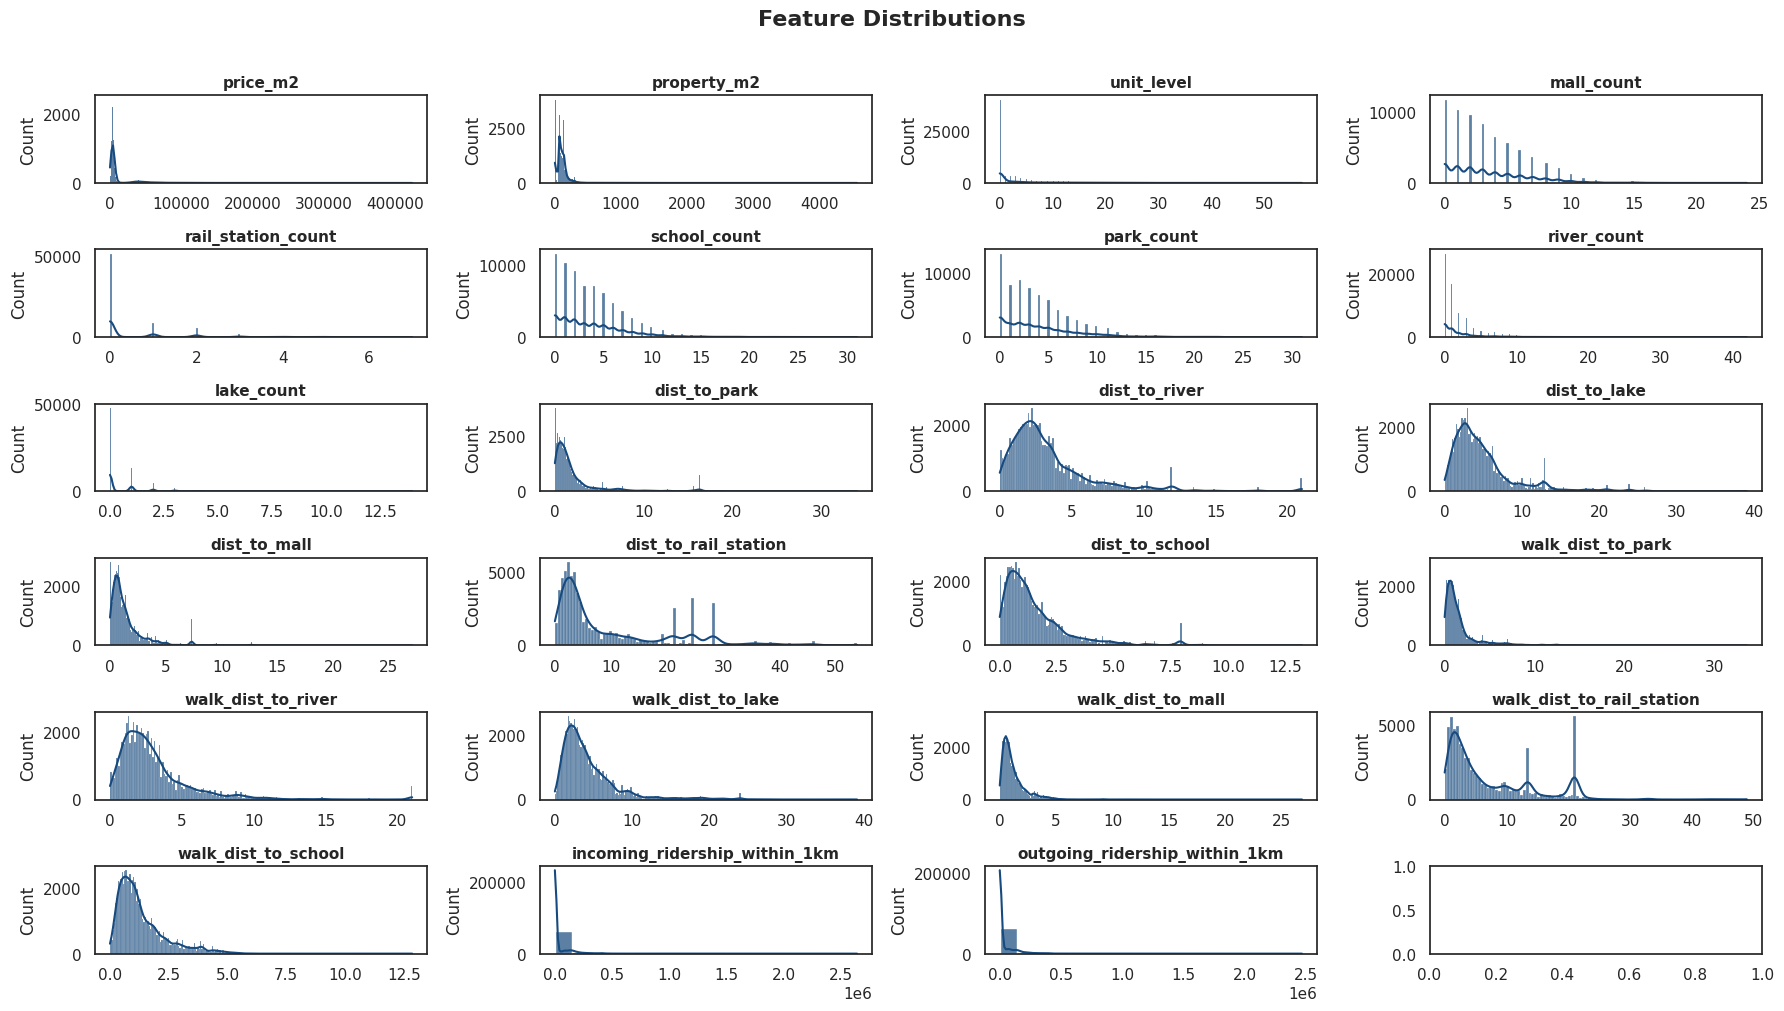

In [8]:
# Distribution plots
key_features = ['price_m2', 'property_m2', 'unit_level', 'mall_count', 'rail_station_count', 'school_count', 'park_count', 'river_count',
                'lake_count', 'dist_to_park', 'dist_to_river', 'dist_to_lake', 'dist_to_mall', 'dist_to_rail_station',
                'dist_to_school', 'walk_dist_to_park', 'walk_dist_to_river', 'walk_dist_to_lake', 'walk_dist_to_mall', 'walk_dist_to_rail_station',
                'walk_dist_to_school','incoming_ridership_within_1km', 'outgoing_ridership_within_1km']

fig, axes = plt.subplots(6, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(key_features):
    sns.histplot(df_clean[col], kde=True, ax=axes[idx], color=COLORS['blue'], alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=11, weight='bold')
    axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions', fontsize=16, weight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [9]:
# FEATURE DEFINITIONS
distance_cols = list(dist_cols)

# Convert pandas Index to list
count_cols = df_clean.columns[df_clean.columns.str.contains("_count")].tolist()

property_cols = ['property_m2', 'unit_level']

ridership_cols = ['incoming_ridership_within_1km', 'outgoing_ridership_within_1km']

# Now this will work because all are Python lists
continuous_features = property_cols + distance_cols + count_cols + ridership_cols
categorical_features = ['property_type', 'market_cluster_id', 'freehold', 'transit', 'district']

# DATA PREPARATION
TARGET_VARIABLE = 'price_m2'
TEST_SIZE = 0.3
RANDOM_STATE = 42

# Temporal split: pre-2025 for training/testing, 2025 for validation
df_pre2025 = df_clean[df_clean['year'] < 2025]
df_2025 = df_clean[df_clean['year'] == 2025]

## Pre 2025
X_pre2025 = df_pre2025.drop(columns=TARGET_VARIABLE)
y_pre2025 = df_pre2025[TARGET_VARIABLE]

## 2025
X_2025 = df_2025.drop(columns=TARGET_VARIABLE)
y_2025 = df_2025[TARGET_VARIABLE]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pre2025, y_pre2025, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Setup OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Setup Preprocessing Scaling Pipeline
log_scale_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('distance', log_scale_pipeline, distance_cols),
        ('counts', log_scale_pipeline, count_cols),
        ('property', log_scale_pipeline, property_cols),
        ('ridership', log_scale_pipeline, ridership_cols)
    ],
    remainder='drop' # or 'passthrough'
)

# FIT TRANSFORMERS
encoder.fit(X_train[categorical_features])
preprocessor.fit(X_train[continuous_features])

# TRANSFORM DATA
def transform_features(X, y=None):
    """Apply fitted preprocessing to dataset"""
    X_continuous = preprocessor.transform(X[continuous_features])
    X_categorical = encoder.transform(X[categorical_features])
    X_transformed = np.hstack([X_continuous, X_categorical])
    y_transformed = np.log1p(y) if y is not None else None
    return X_transformed, y_transformed

# Apply transformations DIFFERENTLY on 3 SETS of data
## Pre 2025
X_train_scaled, y_train_log = transform_features(X_train, y_train)
X_test_scaled, y_test_log = transform_features(X_test, y_test)

## 2025
X_2025_scaled, y_2025_log = transform_features(X_2025, y_2025)

# SUMMARY
print("✅ Preprocessing Complete!")
print(f"\nTrain: {X_train_scaled.shape[0]:,} samples × {X_train_scaled.shape[1]} features, % on full dataset = {round(X_train_scaled.shape[0] / df_clean.shape[0] ,2)}")
print(f"Test:  {X_test_scaled.shape[0]:,} samples × {X_test_scaled.shape[1]} features, % on full dataset = {round(X_test_scaled.shape[0] / df_clean.shape[0],2)}")
print(f"2025:  {X_2025_scaled.shape[0]:,} samples × {X_2025_scaled.shape[1]} features, % on full dataset = {round(X_2025_scaled.shape[0] / df_clean.shape[0],2)}")

✅ Preprocessing Complete!

Train: 46,624 samples × 279 features, % on full dataset = 0.68
Test:  19,982 samples × 279 features, % on full dataset = 0.29
2025:  2,071 samples × 279 features, % on full dataset = 0.03


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Baseline Modeling

## Models Setup

In [19]:
def get_regression_models():
    """
    Initializes and returns a dictionary of scikit-learn compatible regression models.

    Returns:
        dict: A dictionary of model names to model objects.
    """

    # --- Model Dictionary ---
    models = {
        # Linear Models
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1),

        # Non-Linear Models
        "KNeighbors Regressor": KNeighborsRegressor(),

        # Tree-Based Ensemble Models
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),

        # Advanced Gradient Boosting Models
        "XGBoost": xgb.XGBRegressor(
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        "LightGBM": lgb.LGBMRegressor(
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        )
    }

    return models

In [11]:
def calculate_metrics(y_true, y_pred, prefix="", include_mape=True):
    """
    Calculates regression metrics and returns them in a dictionary.

    Args:
        y_true: Actual values
        y_pred: Predicted values
        prefix: Prefix for metric names (e.g., "Train_Log", "Test_Orig")
        include_mape: Whether to include MAPE (only for original scale, not log space)

    Returns:
        Dictionary of metrics
    """
    prefix = f"{prefix} " if prefix else ""

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        f"{prefix}MSE": mse,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}R2": r2
    }

    # Only calculate MAPE if requested (for original space, not log space)
    if include_mape:
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
        metrics[f"{prefix}MAPE"] = mape

    return metrics

In [12]:
def plot_model_performance(model_name, y_train, y_train_pred, y_test, y_test_pred,
                          y_train_original, y_train_pred_original,
                          y_test_original, y_test_pred_original):
    """
    Plots model performance in both log-space and original scale (RM/sqm).

    Args:
        model_name: Name of the model
        y_train, y_train_pred: Training actuals and predictions in LOG SPACE
        y_test, y_test_pred: Test actuals and predictions in LOG SPACE
        y_train_original, y_train_pred_original: Training actuals and predictions in ORIGINAL SCALE
        y_test_original, y_test_pred_original: Test actuals and predictions in ORIGINAL SCALE
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Performance Analysis for: {model_name}', fontsize=16, y=0.995)

    # ===== ROW 1: LOG SPACE =====
    plot_df_train_log = pd.DataFrame({
        'Actual': y_train,
        'Predicted': y_train_pred
    }).sort_values(by='Actual')

    plot_df_test_log = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_test_pred
    }).sort_values(by='Actual')

    # Training Set - Log Space
    sns.lineplot(x=np.arange(len(plot_df_train_log)), y='Predicted',
                data=plot_df_train_log, color='red', label='Predicted Values',
                ax=axes[0, 0], zorder=1)
    sns.scatterplot(x=np.arange(len(plot_df_train_log)), y='Actual',
                   data=plot_df_train_log, label='Actual Values',
                   ax=axes[0, 0], zorder=2, alpha=0.6)
    axes[0, 0].set_title('Training Set - Log Space')
    axes[0, 0].set_xlabel('Sample Index (Sorted by Actual Value)')
    axes[0, 0].set_ylabel('Log(Price)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Test Set - Log Space
    sns.lineplot(x=np.arange(len(plot_df_test_log)), y='Predicted',
                data=plot_df_test_log, color='red', label='Predicted Values',
                ax=axes[0, 1], zorder=1)
    sns.scatterplot(x=np.arange(len(plot_df_test_log)), y='Actual',
                   data=plot_df_test_log, label='Actual Values',
                   ax=axes[0, 1], zorder=2, alpha=0.6)
    axes[0, 1].set_title('Test Set - Log Space')
    axes[0, 1].set_xlabel('Sample Index (Sorted by Actual Value)')
    axes[0, 1].set_ylabel('Log(Price)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # ===== ROW 2: ORIGINAL SCALE (RM/sqm) =====
    plot_df_train_orig = pd.DataFrame({
        'Actual': y_train_original,
        'Predicted': y_train_pred_original
    }).sort_values(by='Actual')

    plot_df_test_orig = pd.DataFrame({
        'Actual': y_test_original,
        'Predicted': y_test_pred_original
    }).sort_values(by='Actual')

    # Training Set - Original Scale
    sns.lineplot(x=np.arange(len(plot_df_train_orig)), y='Predicted',
                data=plot_df_train_orig, color='red', label='Predicted Values',
                ax=axes[1, 0], zorder=1)
    sns.scatterplot(x=np.arange(len(plot_df_train_orig)), y='Actual',
                   data=plot_df_train_orig, label='Actual Values',
                   ax=axes[1, 0], zorder=2, alpha=0.6)
    axes[1, 0].set_title('Training Set - Original Scale (RM/sqm)')
    axes[1, 0].set_xlabel('Sample Index (Sorted by Actual Value)')
    axes[1, 0].set_ylabel('Price (RM/sqm)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # Test Set - Original Scale
    sns.lineplot(x=np.arange(len(plot_df_test_orig)), y='Predicted',
                data=plot_df_test_orig, color='red', label='Predicted Values',
                ax=axes[1, 1], zorder=1)
    sns.scatterplot(x=np.arange(len(plot_df_test_orig)), y='Actual',
                   data=plot_df_test_orig, label='Actual Values',
                   ax=axes[1, 1], zorder=2, alpha=0.6)
    axes[1, 1].set_title('Test Set - Original Scale (RM/sqm)')
    axes[1, 1].set_xlabel('Sample Index (Sorted by Actual Value)')
    axes[1, 1].set_ylabel('Price (RM/sqm)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [13]:
def train_test_plot(X_train, X_test, y_train, y_test,
                   y_train_original, y_test_original, cv=10):
    """
    Evaluates models using k-fold CV on the train set, then does a final
    fit and test on the hold-out test set. Ranks models and plots performance.
    NOW INCLUDES:
    - MAPE in original scale only (not log space)
    - Returns trained models for export

    Args:
        X_train, X_test: Training and testing features (preprocessed)
        y_train, y_test: Training and testing targets in LOG SPACE (log1p transformed)
        y_train_original, y_test_original: Training and testing targets in ORIGINAL SCALE (RM/sqm)
        cv (int): The number of folds for cross-validation on the train set. Defaults to 10.

    Returns:
        results_df: DataFrame with comprehensive metrics
        trained_models: Dictionary mapping model names to fitted model objects
    """
    all_models = get_regression_models()
    model_predictions = {}
    trained_models = {}
    results = []

    # Define the K-Fold strategy for the training set
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)

    print("--- Starting Model Training and Evaluation ---")

    for name, model in all_models.items():
        print(f"Processing: {name}...")

        try:
            # Stage 1: Cross-Validation on the Training Set (Log Space)
            scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
            cv_results = cross_validate(model, X_train, y_train, cv=kfold,
                                       scoring=scoring, n_jobs=-1)


            # Stage 2: Final Training and Evaluation on Test Set
            model.fit(X_train, y_train)

            # Store the trained model
            trained_models[name] = model

            y_train_pred_log = model.predict(X_train)
            y_test_pred_log = model.predict(X_test)


            # Stage 3: Inverse Transform to Original Scale
            y_train_pred_original = np.expm1(y_train_pred_log)
            y_test_pred_original = np.expm1(y_test_pred_log)

            # Store predictions for plotting (both scales)
            model_predictions[name] = {
                'log': (y_train_pred_log, y_test_pred_log),
                'original': (y_train_pred_original, y_test_pred_original)
            }

            # Calculate Metrics in LOG SPACE (NO MAPE)
            train_metrics_log = calculate_metrics(y_train, y_train_pred_log,
                                                  prefix="Train_Log", include_mape=False)
            test_metrics_log = calculate_metrics(y_test, y_test_pred_log,
                                                prefix="Test_Log", include_mape=False)
            cv_metrics_log = {
                "CV_Log R2": np.mean(cv_results['test_r2']),
                "CV_Log RMSE": np.sqrt(np.mean(-cv_results['test_neg_mean_squared_error'])),
                "CV_Log MAE": np.mean(-cv_results['test_neg_mean_absolute_error'])
            }

            # Calculate Metrics in ORIGINAL SCALE (WITH MAPE)
            train_metrics_orig = calculate_metrics(y_train_original, y_train_pred_original,
                                                  prefix="Train_Orig", include_mape=True)
            test_metrics_orig = calculate_metrics(y_test_original, y_test_pred_original,
                                                 prefix="Test_Orig", include_mape=True)

            # Combine all metrics
            results.append({
                "Model": name,
                **train_metrics_log, **cv_metrics_log, **test_metrics_log,
                **train_metrics_orig, **test_metrics_orig
            })

            print(f"✅ {name} trained and evaluated successfully!")


        except Exception as e:
            print(f"!!! Could not train or evaluate {name}. Error: {e}")

    print("\n--- Initial Evaluation Complete ---")

    if not results:
        print("!!! No models were successfully evaluated.")
        return None, None

    results_df = pd.DataFrame(results)

    # Sort by Test R2 in log space
    results_df = results_df.sort_values(by='Test_Log R2', ascending=False).reset_index(drop=True)
    results_df['Ranking'] = results_df.index + 1

    # Reorder columns - LOG SPACE METRICS FIRST, then ORIGINAL SCALE WITH MAPE
    cols = [
        'Ranking', 'Model',
        # Log Space Metrics (no MAPE)
        'Train_Log R2', 'CV_Log R2', 'Test_Log R2',
        'Train_Log RMSE', 'CV_Log RMSE', 'Test_Log RMSE',
        'Train_Log MAE', 'CV_Log MAE', 'Test_Log MAE',
        # Original Scale Metrics (WITH MAPE)
        'Train_Orig R2', 'Test_Orig R2',
        'Train_Orig RMSE', 'Test_Orig RMSE',
        'Train_Orig MAE', 'Test_Orig MAE',
        'Train_Orig MAPE', 'Test_Orig MAPE'
    ]
    results_df = results_df[[c for c in cols if c in results_df.columns]]

    # --- Plotting Loop for All Models ---
    print(f"\n--- Visualizing Performance For All Models ---")
    for model_name in results_df['Model']:
        if model_name in model_predictions:
            y_train_pred_log, y_test_pred_log = model_predictions[model_name]['log']
            y_train_pred_orig, y_test_pred_orig = model_predictions[model_name]['original']

            plot_model_performance(
                model_name,
                y_train, y_train_pred_log,
                y_test, y_test_pred_log,
                y_train_original, y_train_pred_orig,
                y_test_original, y_test_pred_orig
            )
        else:
            print(f"Warning: Could not find predictions for model '{model_name}'.")

    return results_df, trained_models

## Train Test Plot Scaled Dataset

### Pre 2025 Test

--- Starting Model Training and Evaluation ---
Processing: Linear Regression...
✅ Linear Regression trained and evaluated successfully!
Processing: Ridge...
✅ Ridge trained and evaluated successfully!
Processing: Lasso...
✅ Lasso trained and evaluated successfully!
Processing: KNeighbors Regressor...
✅ KNeighbors Regressor trained and evaluated successfully!
Processing: Decision Tree...
✅ Decision Tree trained and evaluated successfully!
Processing: Random Forest...
✅ Random Forest trained and evaluated successfully!
Processing: XGBoost...
✅ XGBoost trained and evaluated successfully!
Processing: LightGBM...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ LightGBM trained and evaluated successfully!

--- Initial Evaluation Complete ---

--- Visualizing Performance For All Models ---


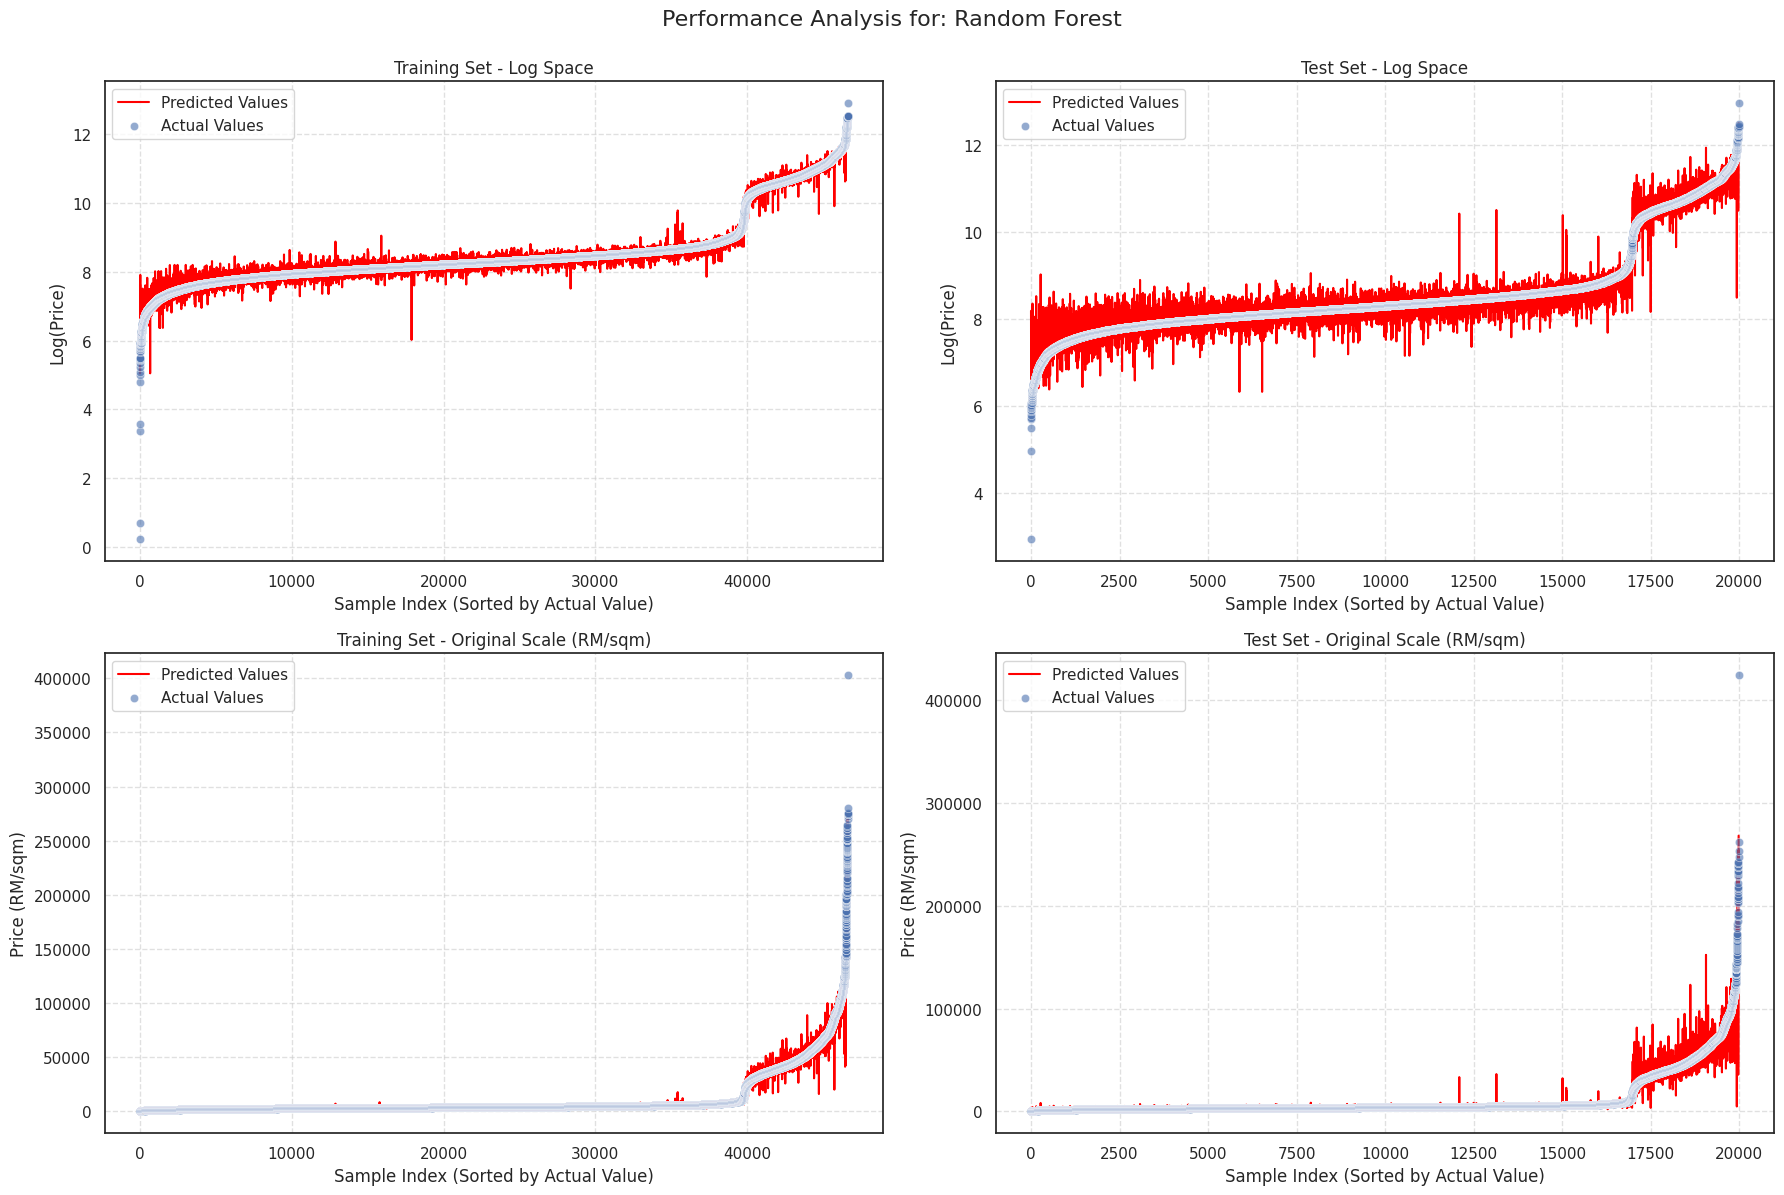

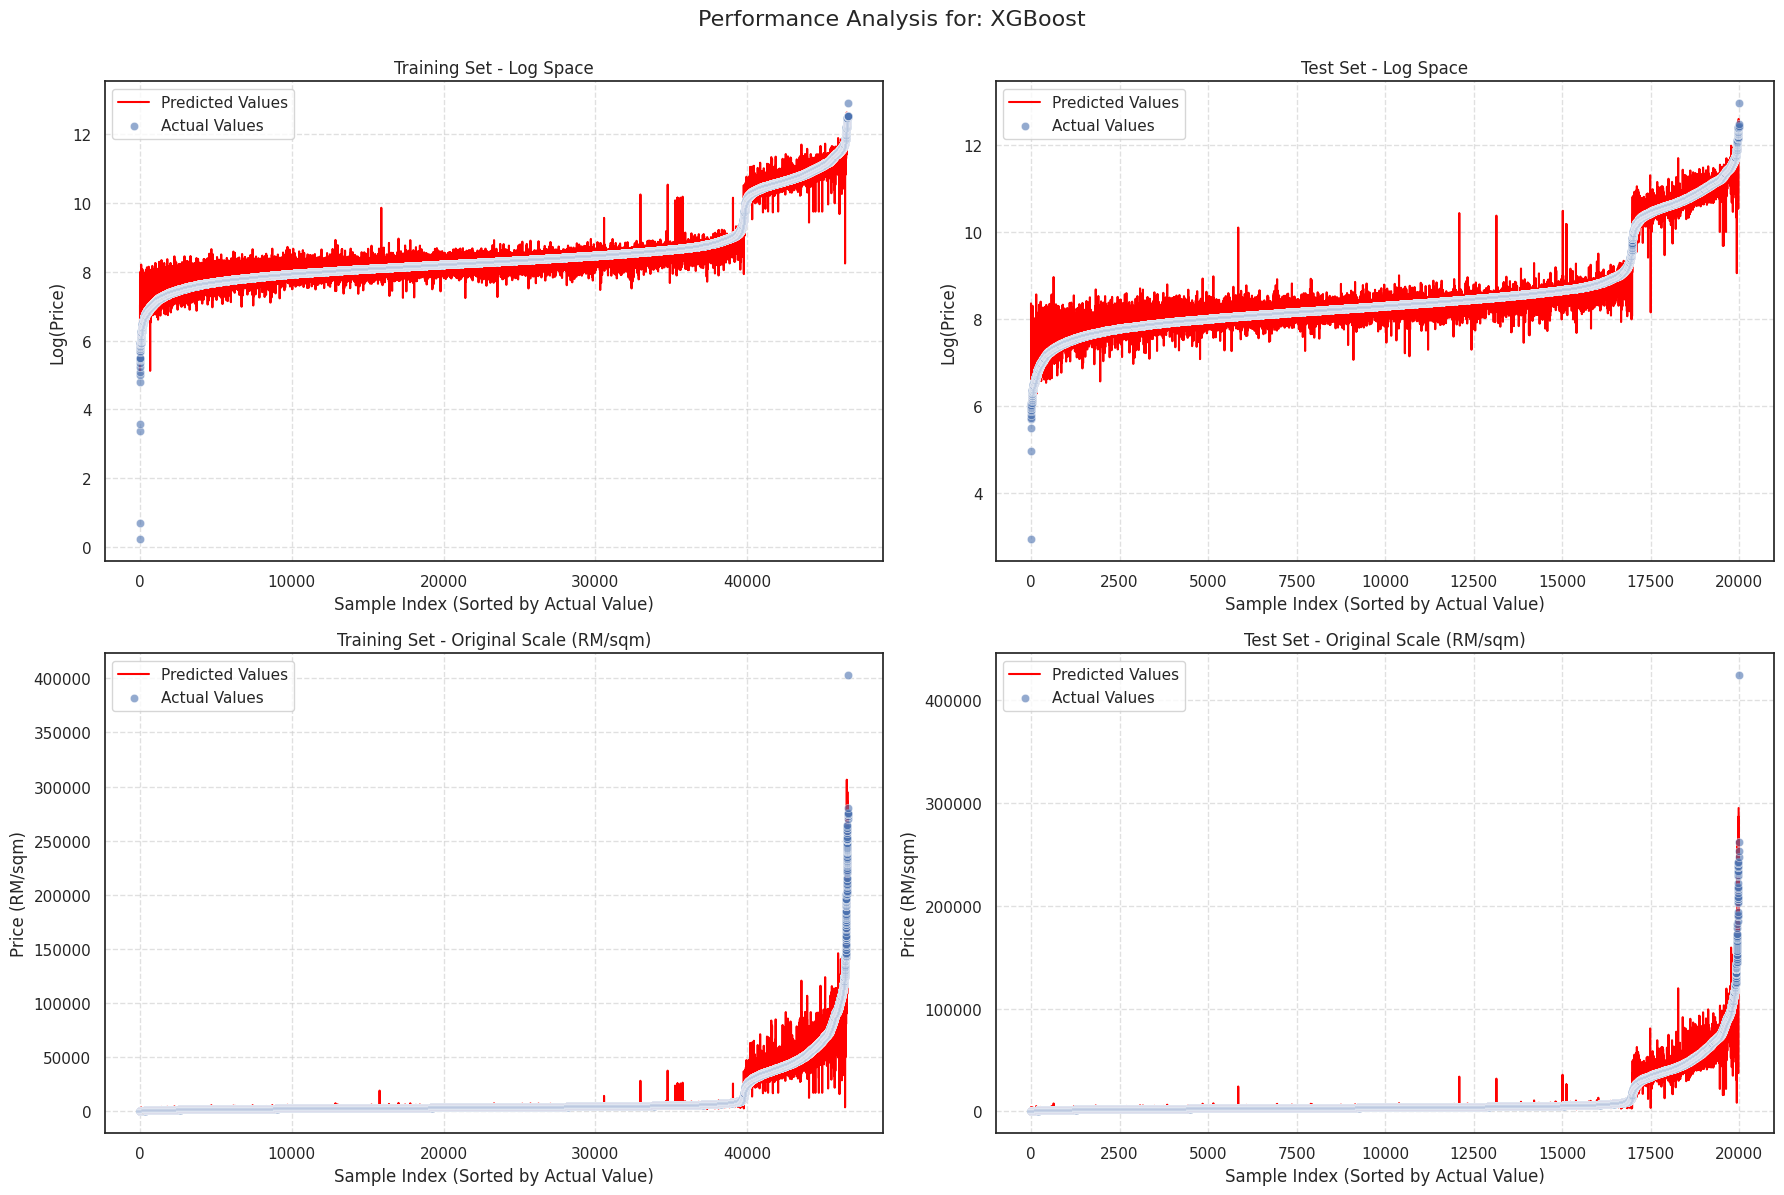

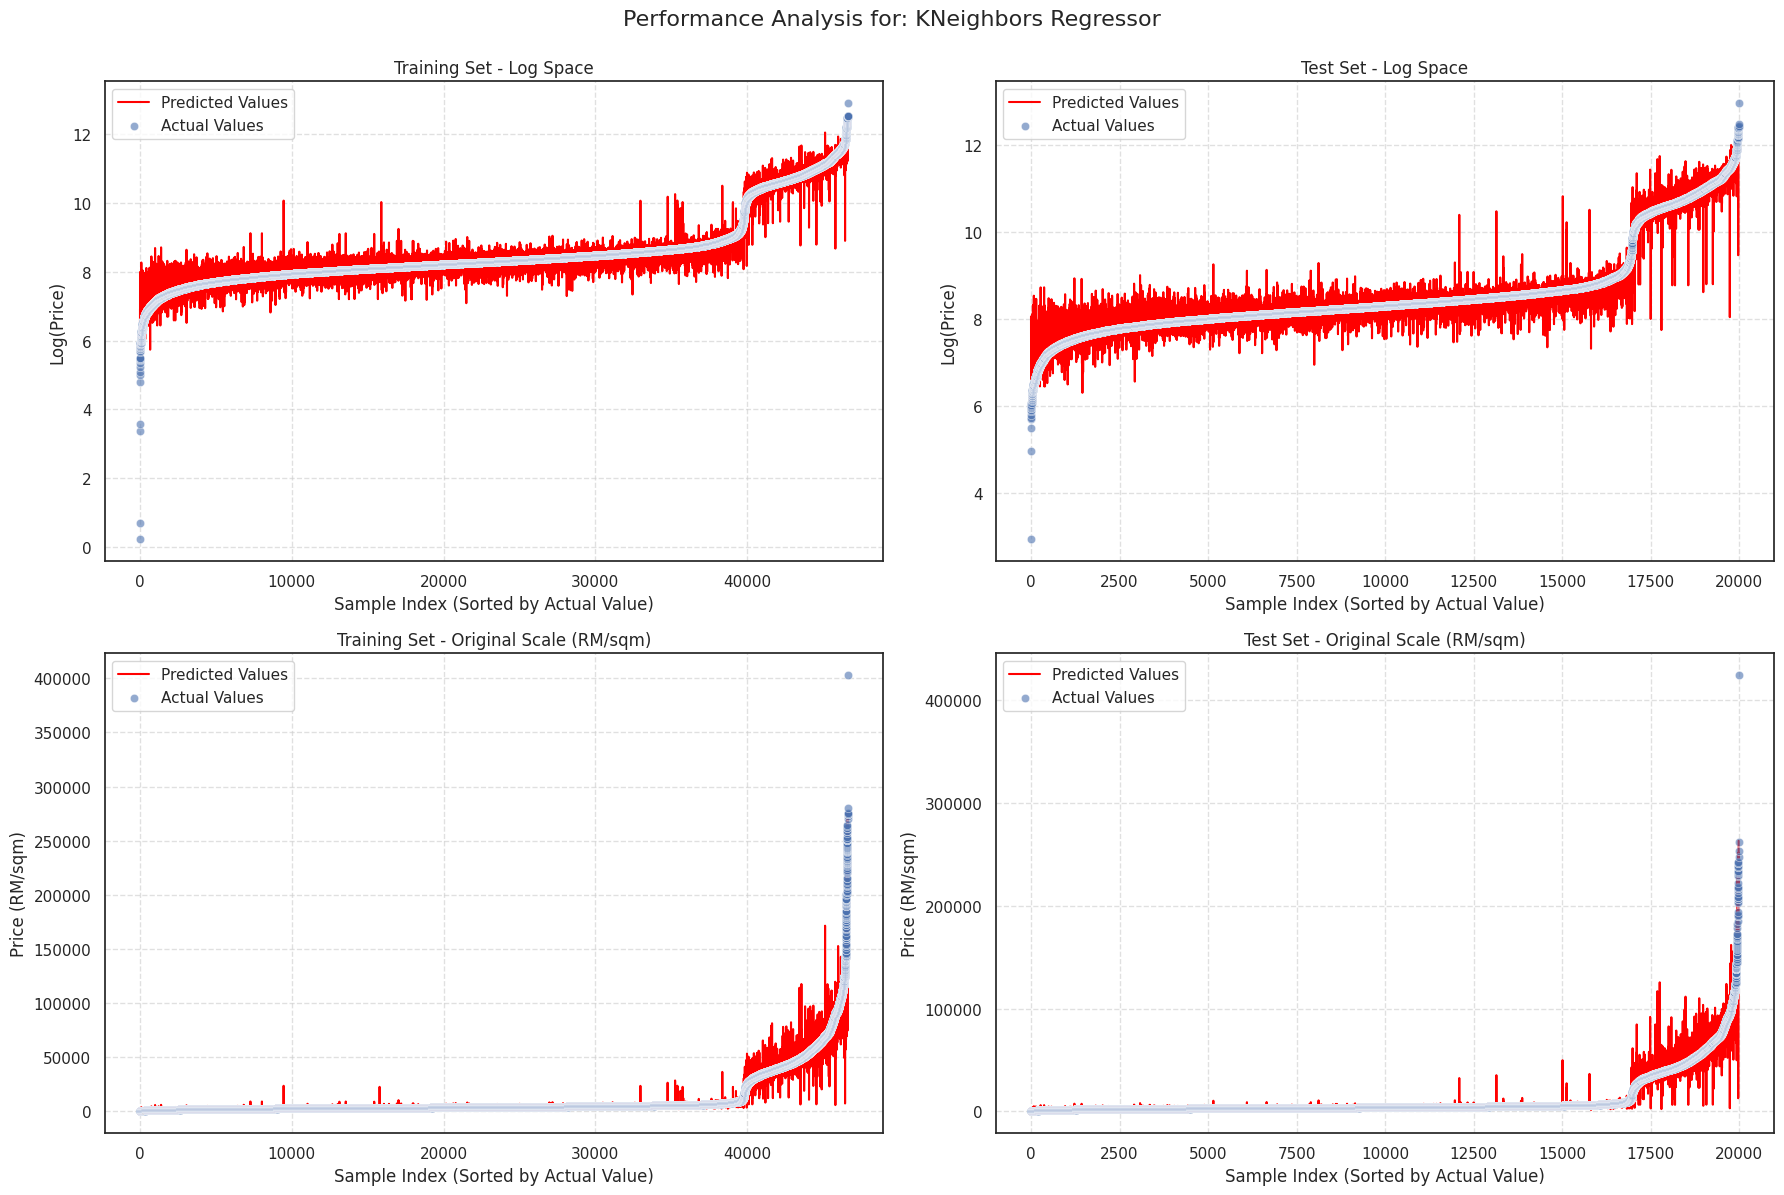

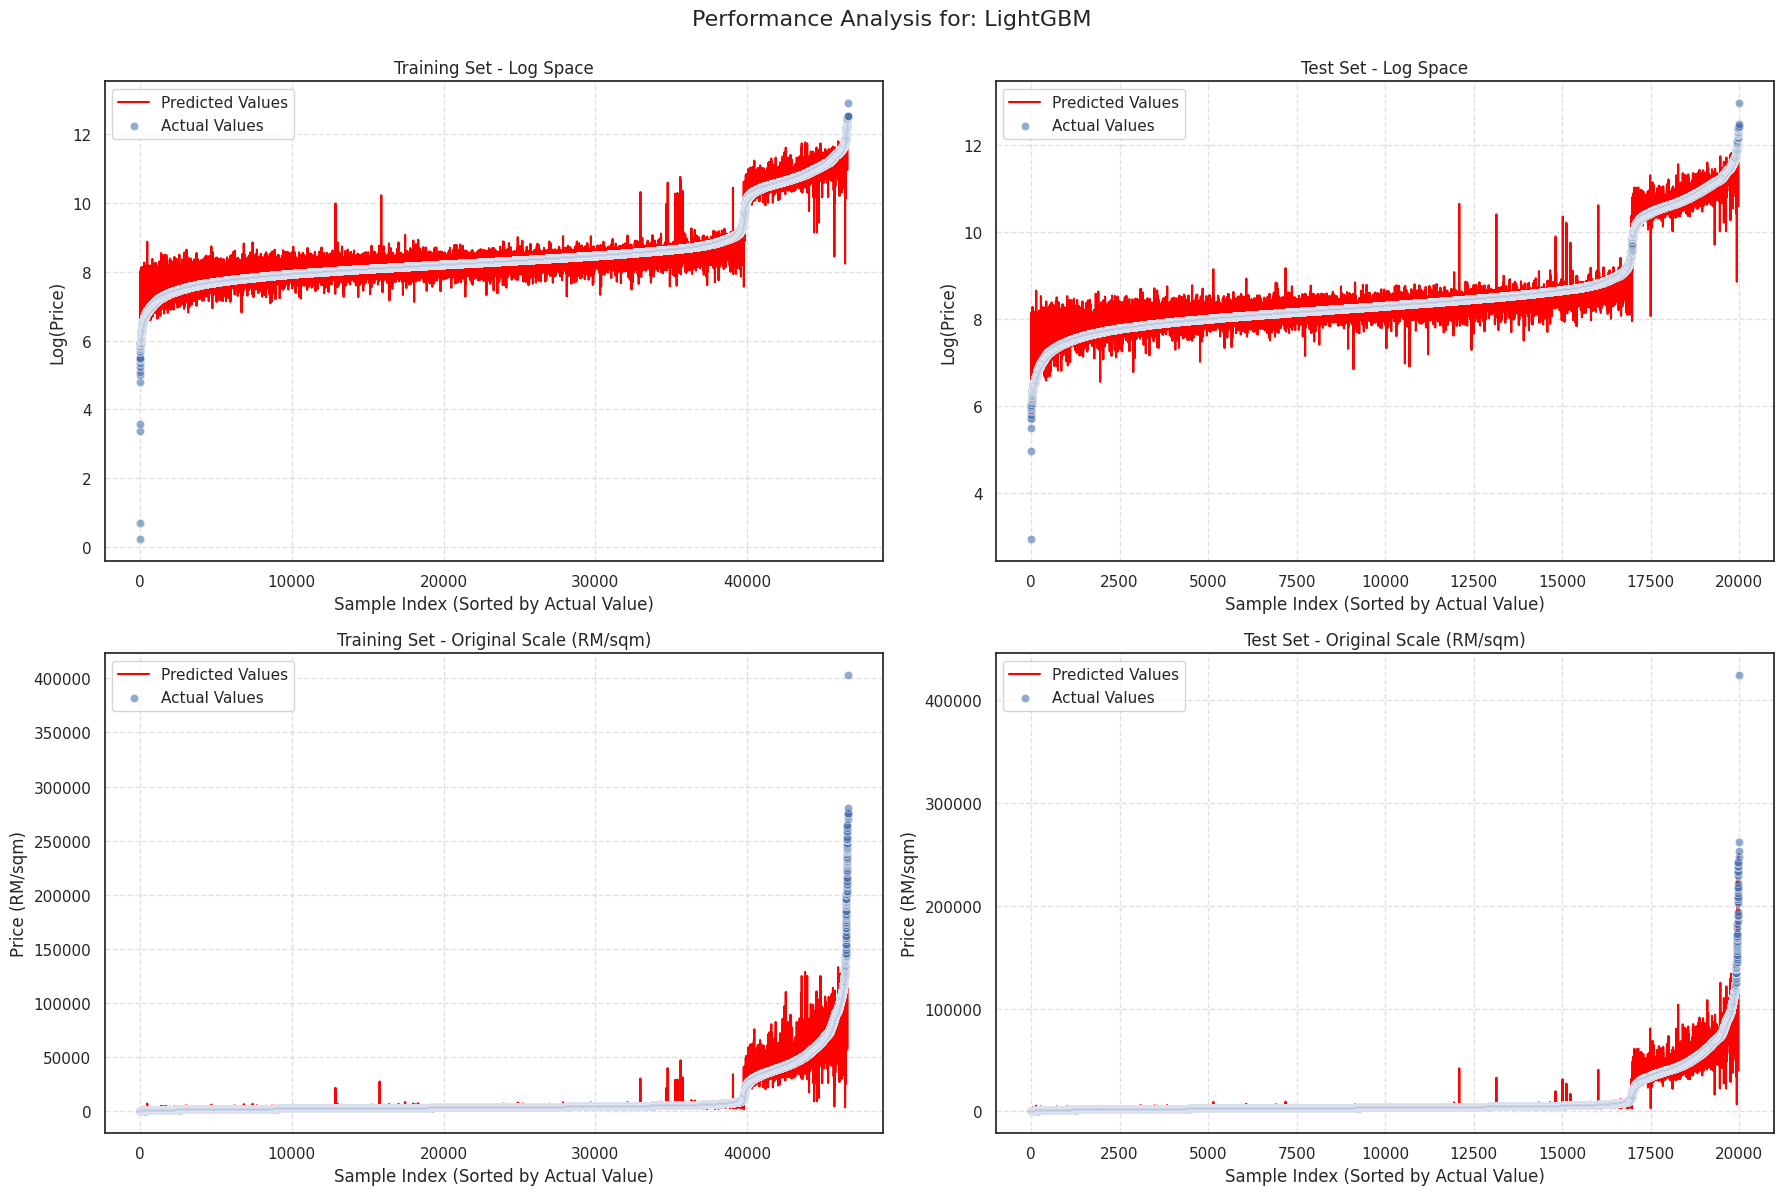

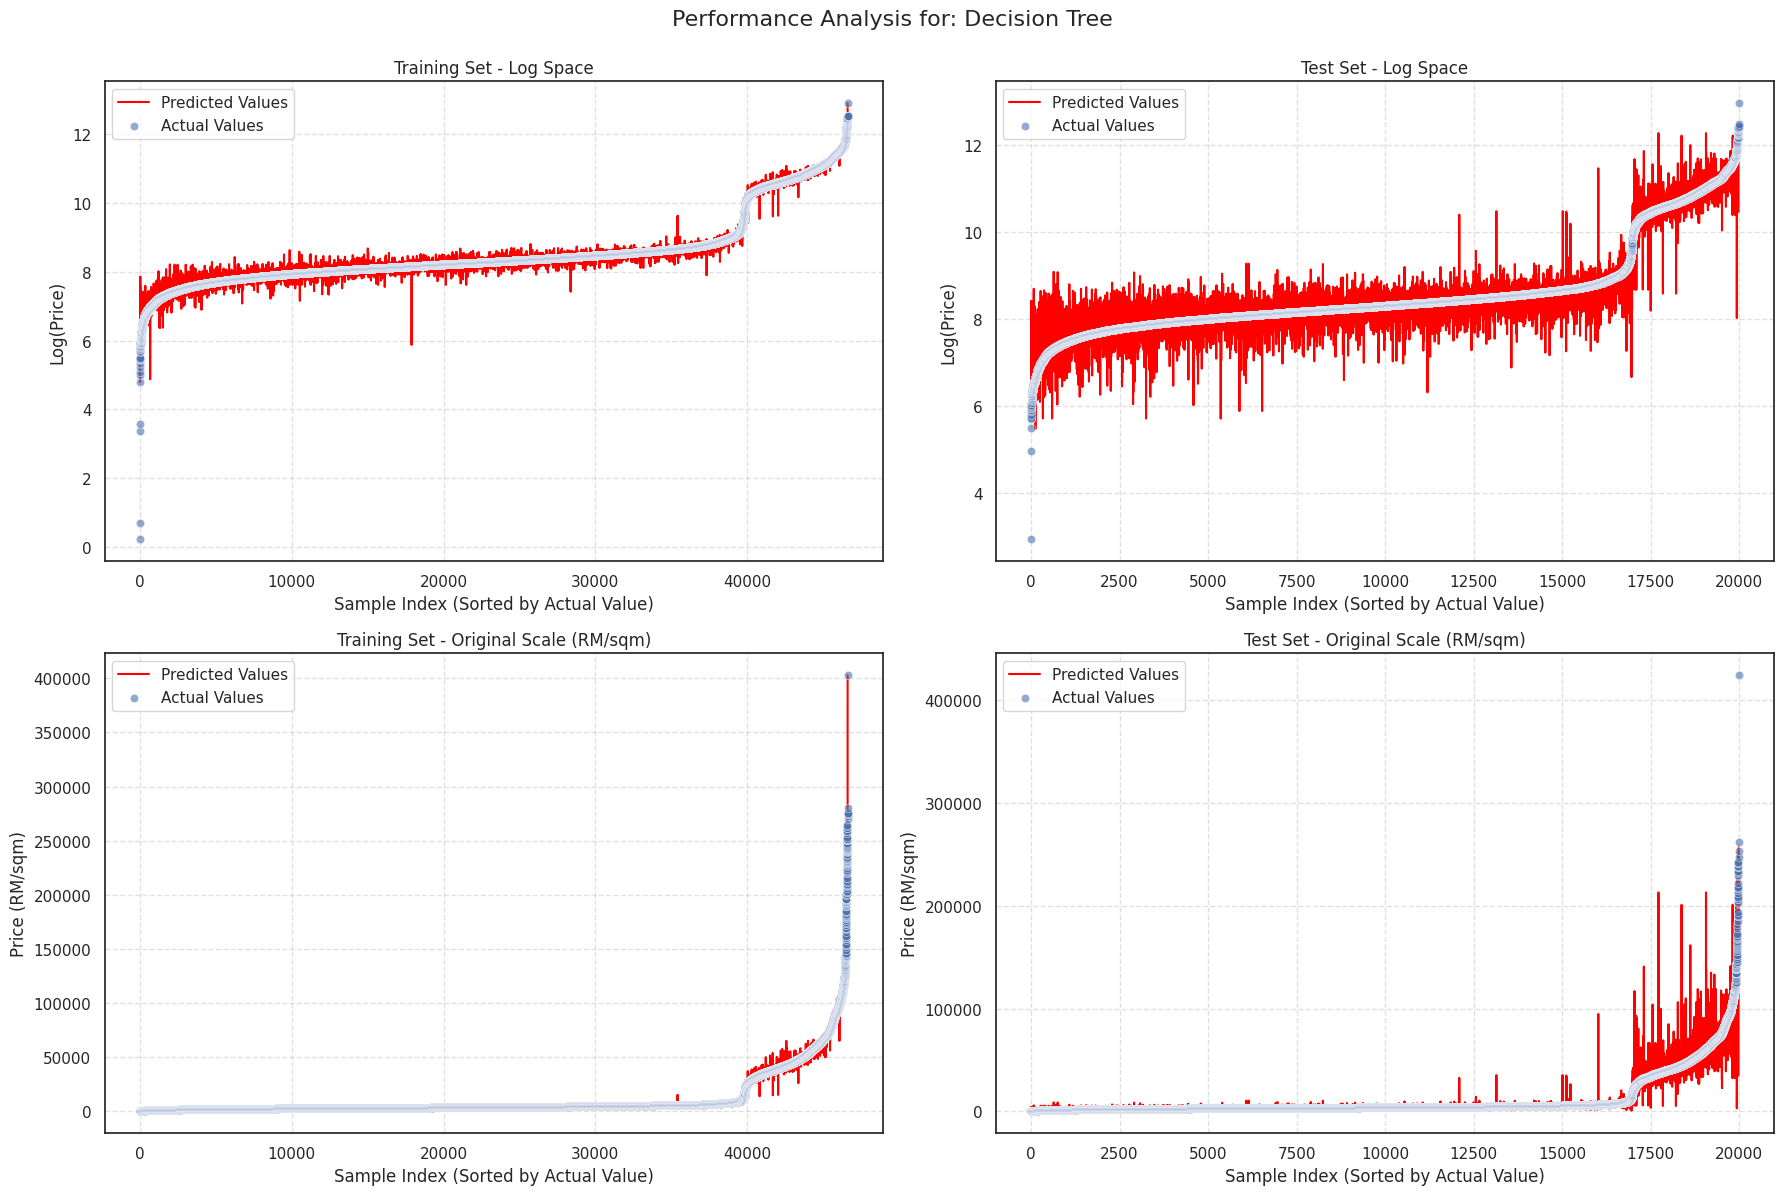

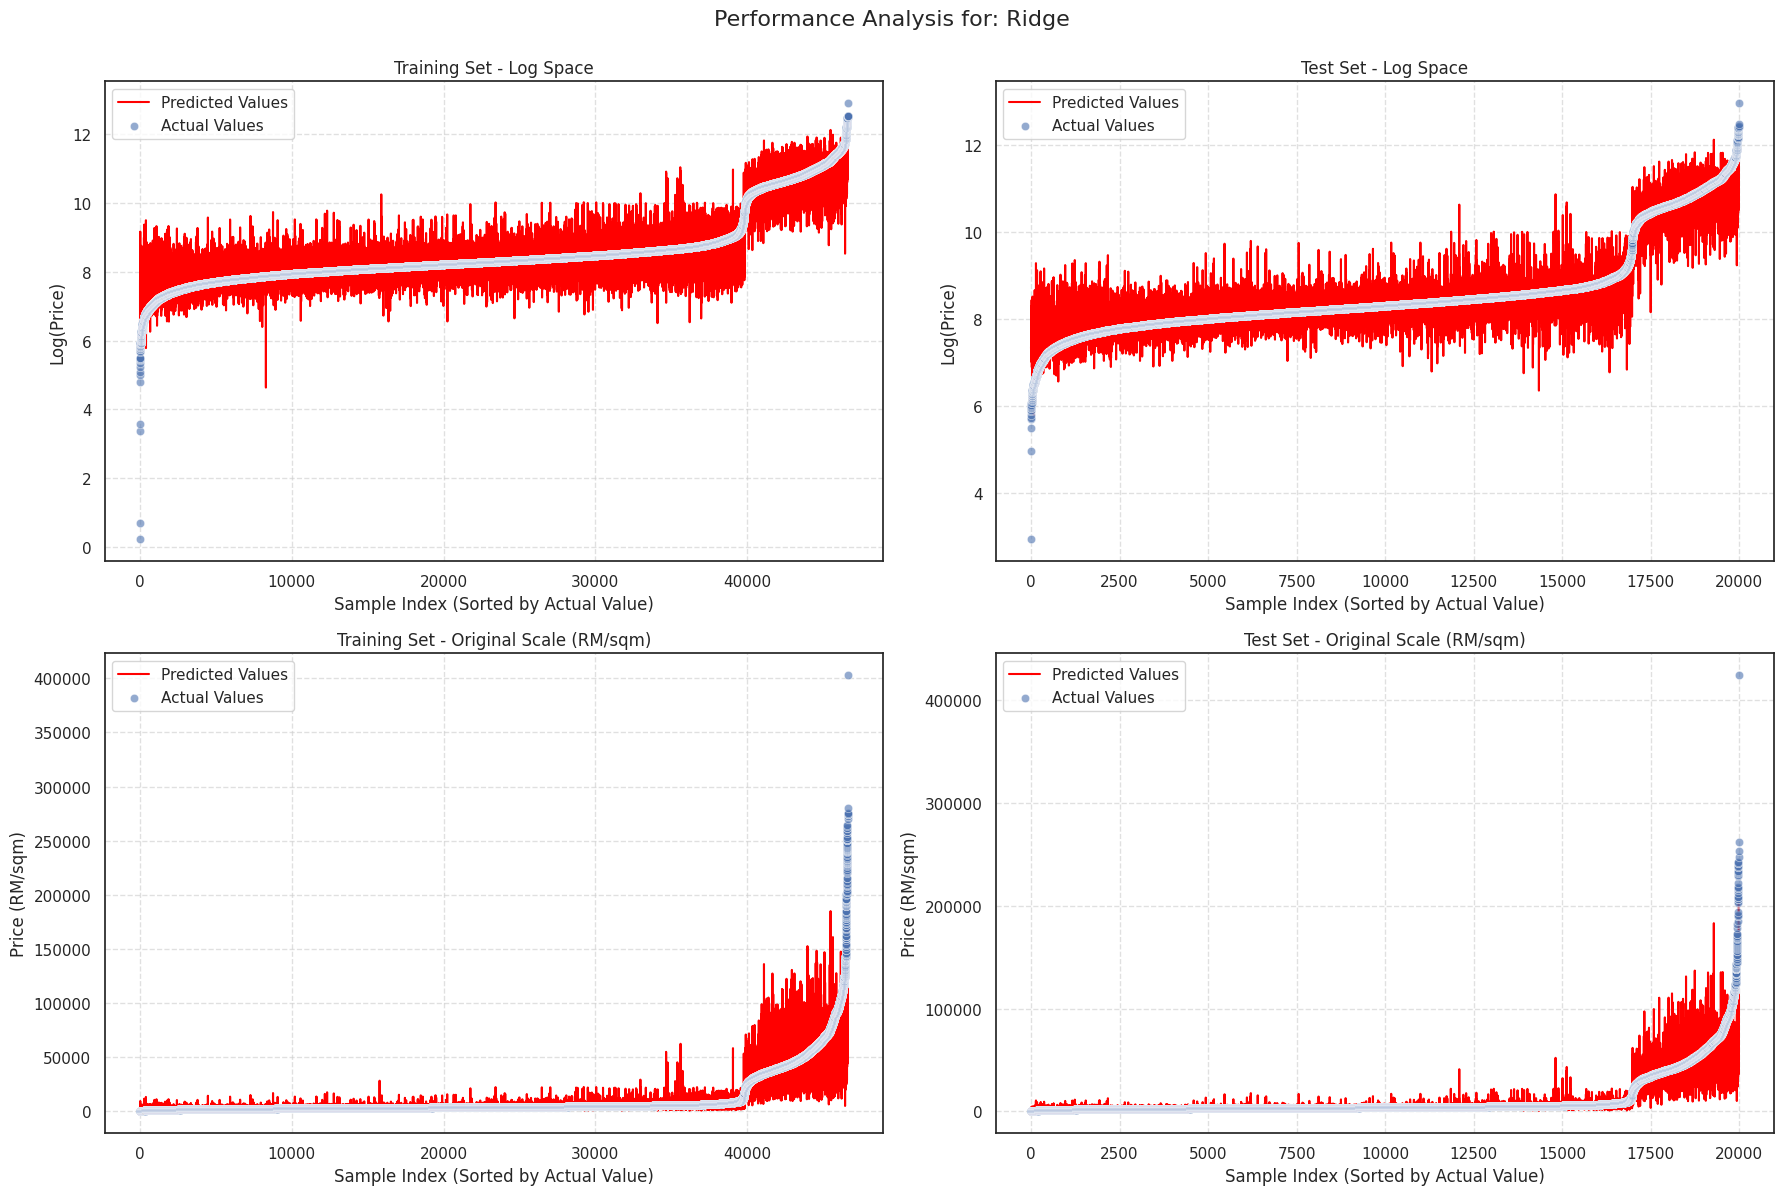

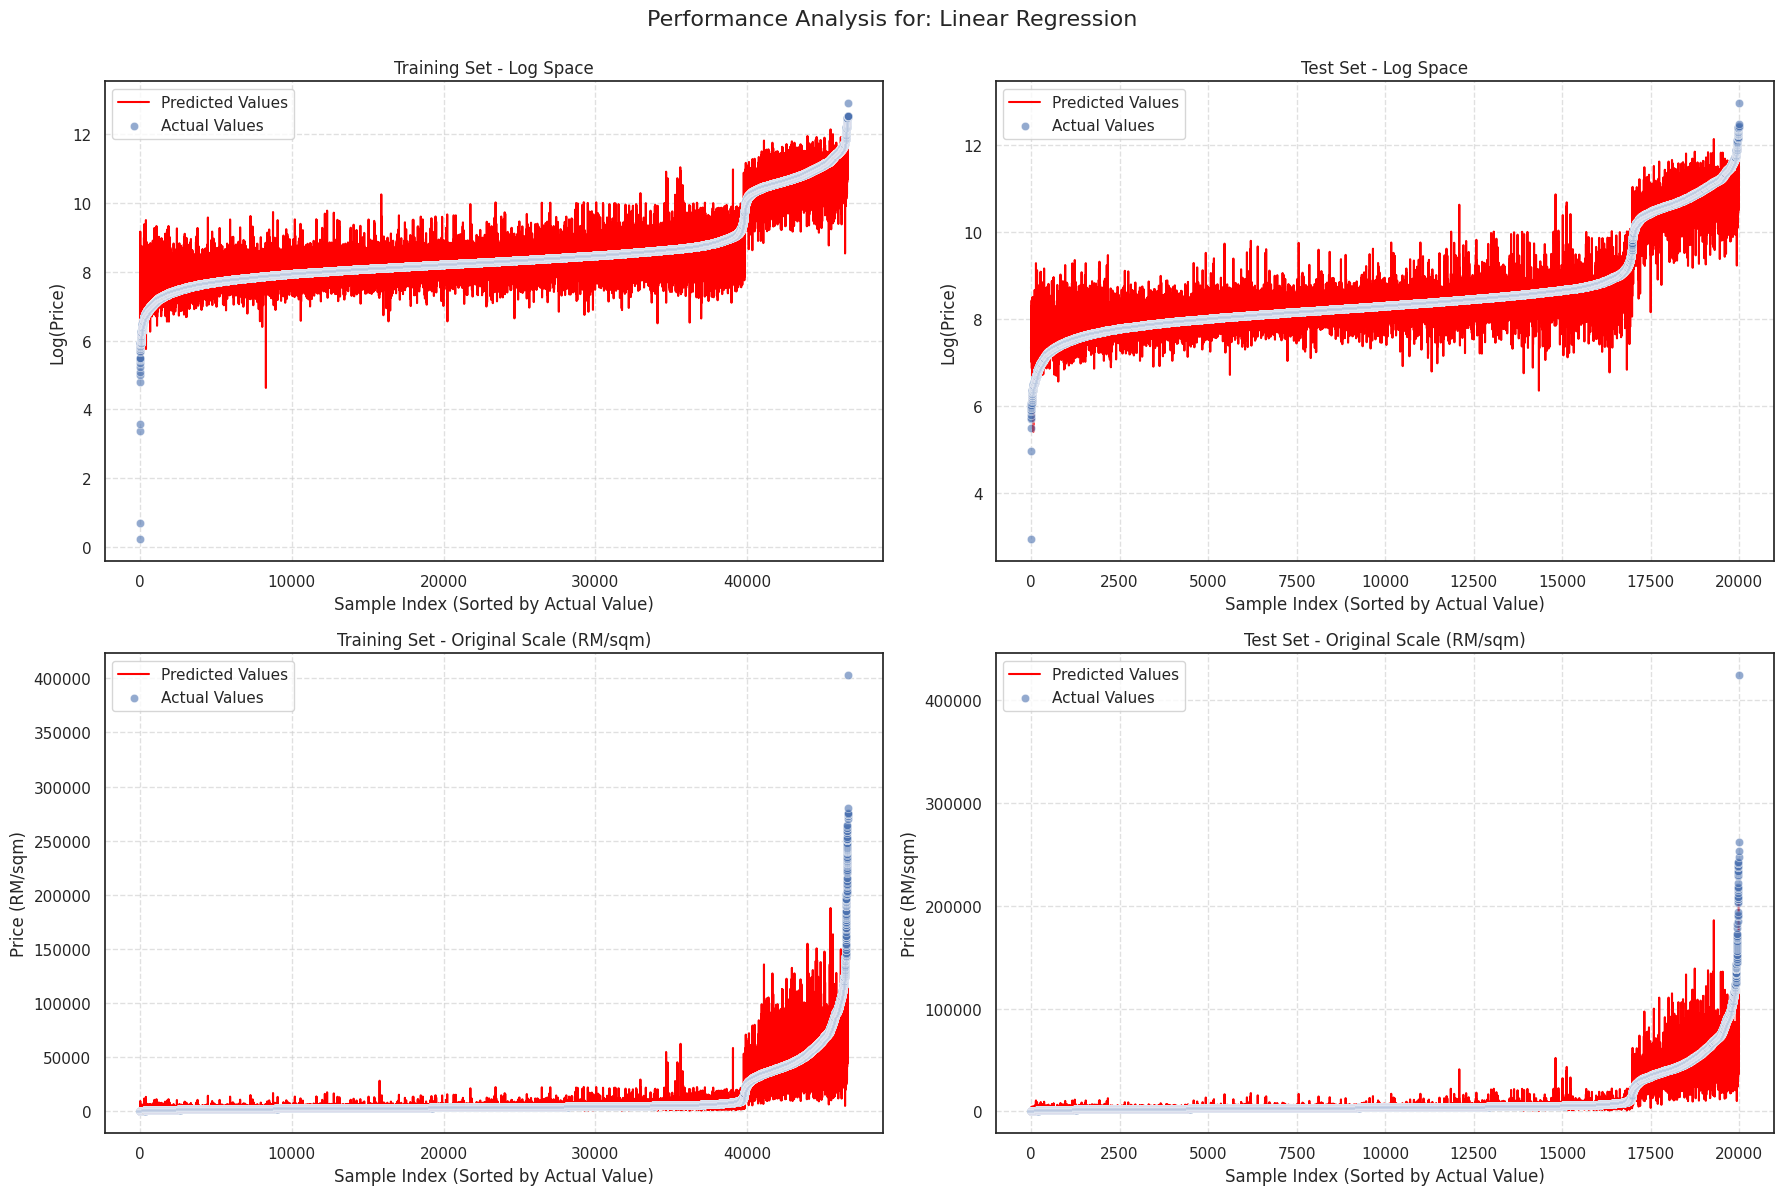

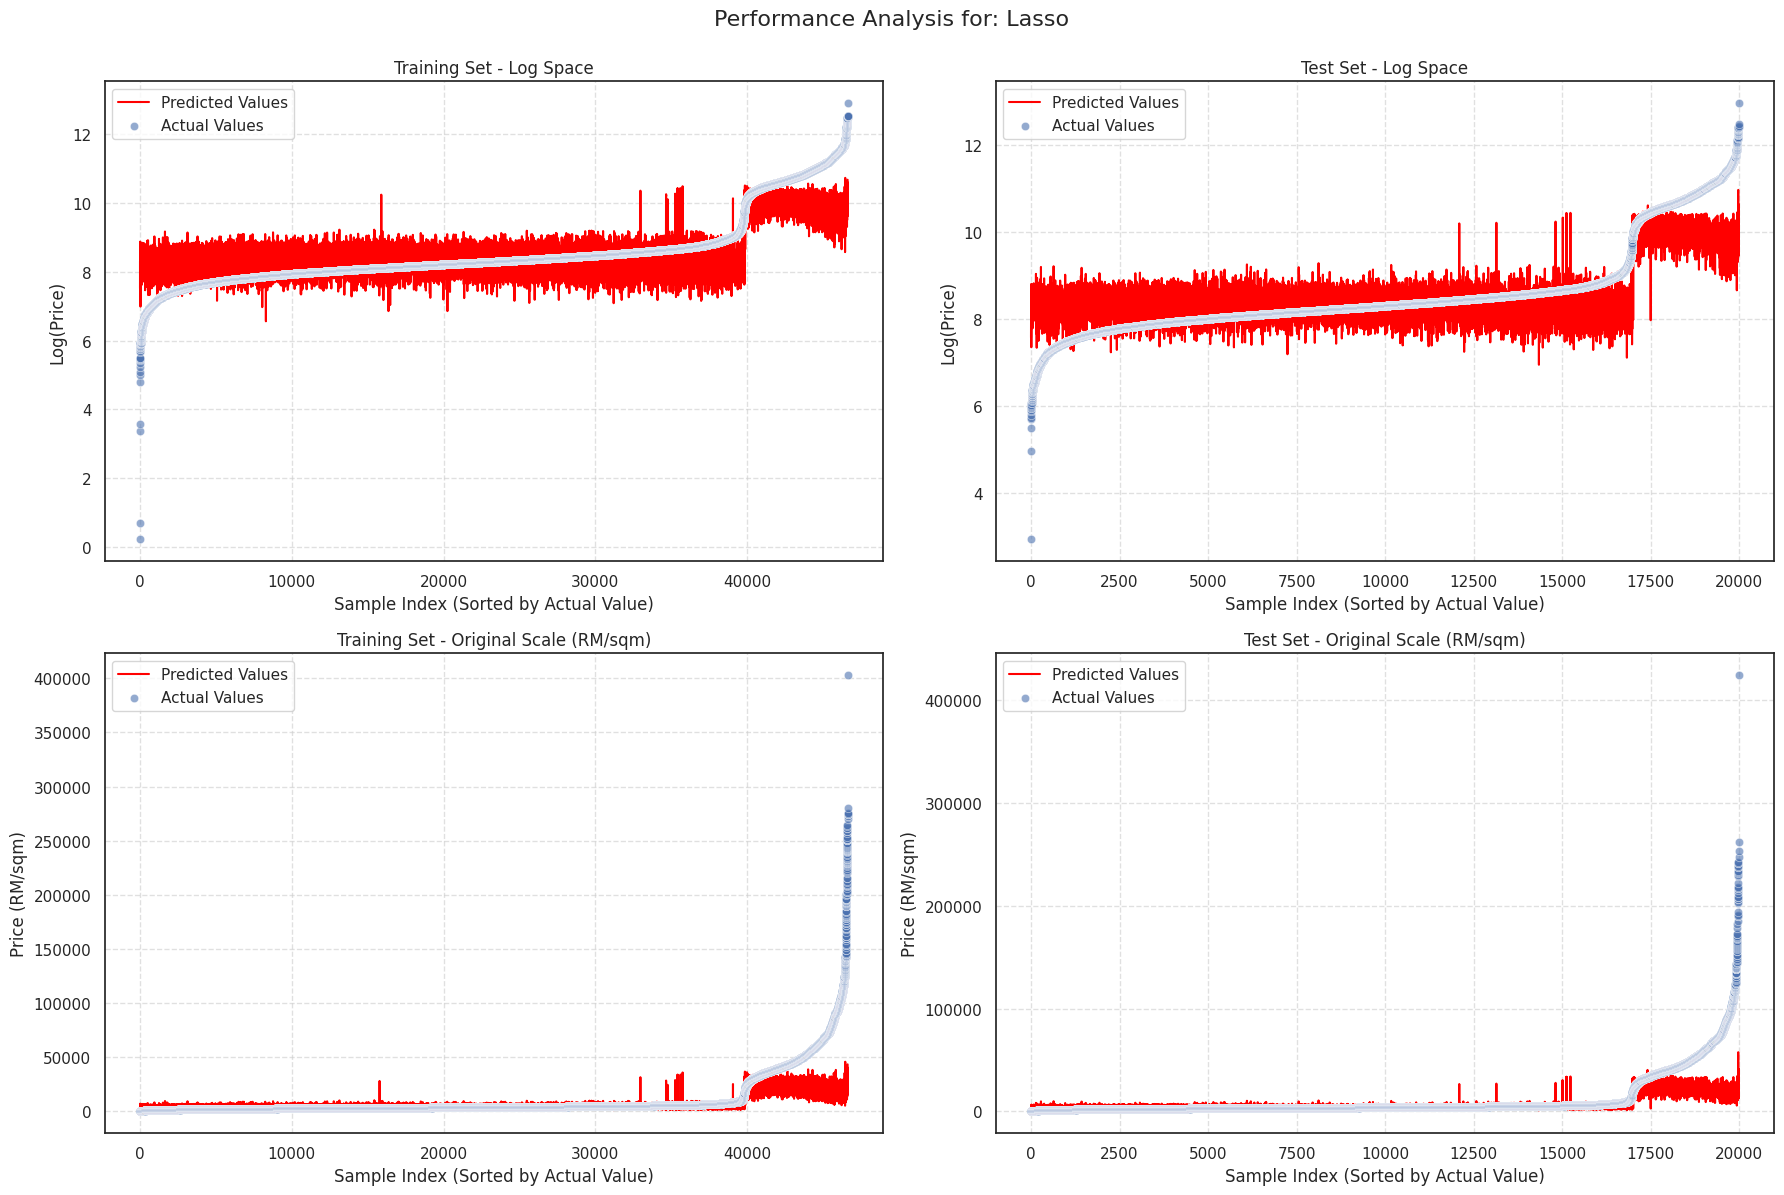

Ranking                 Model  Train_Log R2  CV_Log R2  Test_Log R2  \
0        1         Random Forest          0.99       0.95         0.95   
1        2               XGBoost          0.95       0.94         0.94   
2        3  KNeighbors Regressor          0.96       0.94         0.94   
3        4              LightGBM          0.94       0.93         0.94   
4        5         Decision Tree          0.99       0.92         0.93   
5        6                 Ridge          0.83       0.83         0.84   
6        7     Linear Regression          0.83       0.83         0.84   
7        8                 Lasso          0.60       0.60         0.61   

   Train_Log RMSE  CV_Log RMSE  Test_Log RMSE  Train_Log MAE  CV_Log MAE  \
0            0.11         0.23           0.22           0.07        0.15   
1            0.22         0.25           0.25           0.16        0.18   
2            0.20         0.26           0.25           0.13        0.17   
3            0.25         0.27           0.26           0.18        0.19   
4            0.09         0.29           0.28           0.03        0.18   
5            0.43         0.43           0.42           0.31        0.31   
6            0.43         0.43           0.43           0.31        0.31   
7            0.66         0.66           0.66           0.51        0.51   

   Test_Log MAE  Train_Orig R2  Test_Orig R2  Train_Orig RMSE  Test_Orig RMSE  \
0          0.15           0.99          0.95          2318.51         5039.17   
1          0.17           0.95          0.93          5119.35         5747.28   
2          0.16           0.96          0.94          4274.06         5244.45   
3          0.19           0.92          0.91          6375.10         6547.01   
4          0.18           1.00          0.92           775.69         6183.98   
5          0.31           0.71          0.69         11950.41        12321.18   
6          0.31           0.71          0.69         11950.85        12331.16   
7          0.50           0.33          0.32         18361.17        18312.85   

   Train_Orig MAE  Test_Orig MAE  Train_Orig MAPE  Test_Orig MAPE  
0          623.17        1477.59            12.50           16.56  
1         1694.81        1881.77            27.16           19.56  
2         1258.06        1623.08            23.64           18.58  
3         2040.12        2142.45            32.39           20.83  
4          166.55        1777.02             8.44           20.37  
5         3984.99        4089.66            56.10           34.49  
6         3981.84        4092.20            56.14           34.50  
7         6445.38        6560.95            97.78           57.79

In [14]:
perf_pre2025, trained_models = train_test_plot(X_train_scaled, X_test_scaled,
                             y_train_log, y_test_log,
                             y_train, y_test,
                             cv =10)
perf_pre2025

### Temporal 2025 Holdout

--- Starting Model Training and Evaluation ---
Processing: Linear Regression...
✅ Linear Regression trained and evaluated successfully!
Processing: Ridge...
✅ Ridge trained and evaluated successfully!
Processing: Lasso...
✅ Lasso trained and evaluated successfully!
Processing: KNeighbors Regressor...
✅ KNeighbors Regressor trained and evaluated successfully!
Processing: Decision Tree...
✅ Decision Tree trained and evaluated successfully!
Processing: Random Forest...
✅ Random Forest trained and evaluated successfully!
Processing: XGBoost...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ XGBoost trained and evaluated successfully!
Processing: LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ LightGBM trained and evaluated successfully!

--- Initial Evaluation Complete ---

--- Visualizing Performance For All Models ---


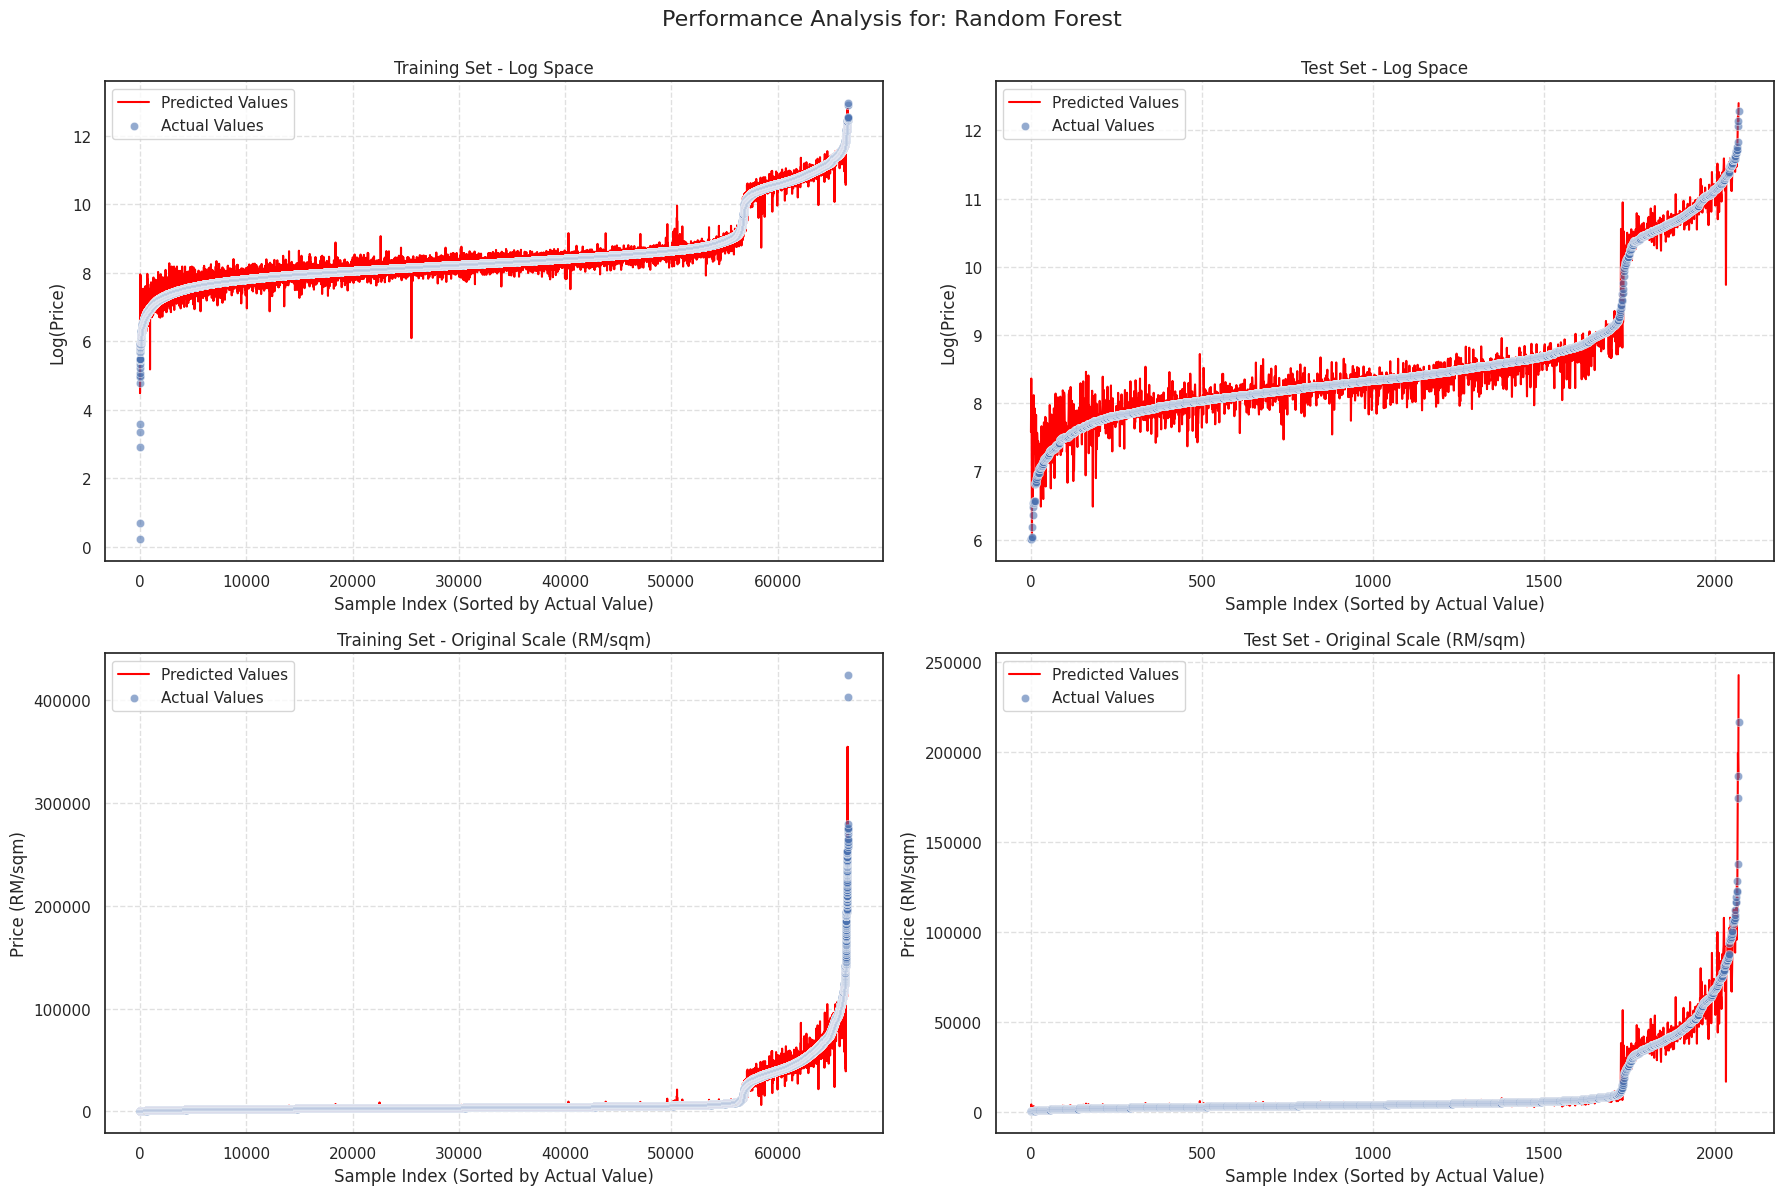

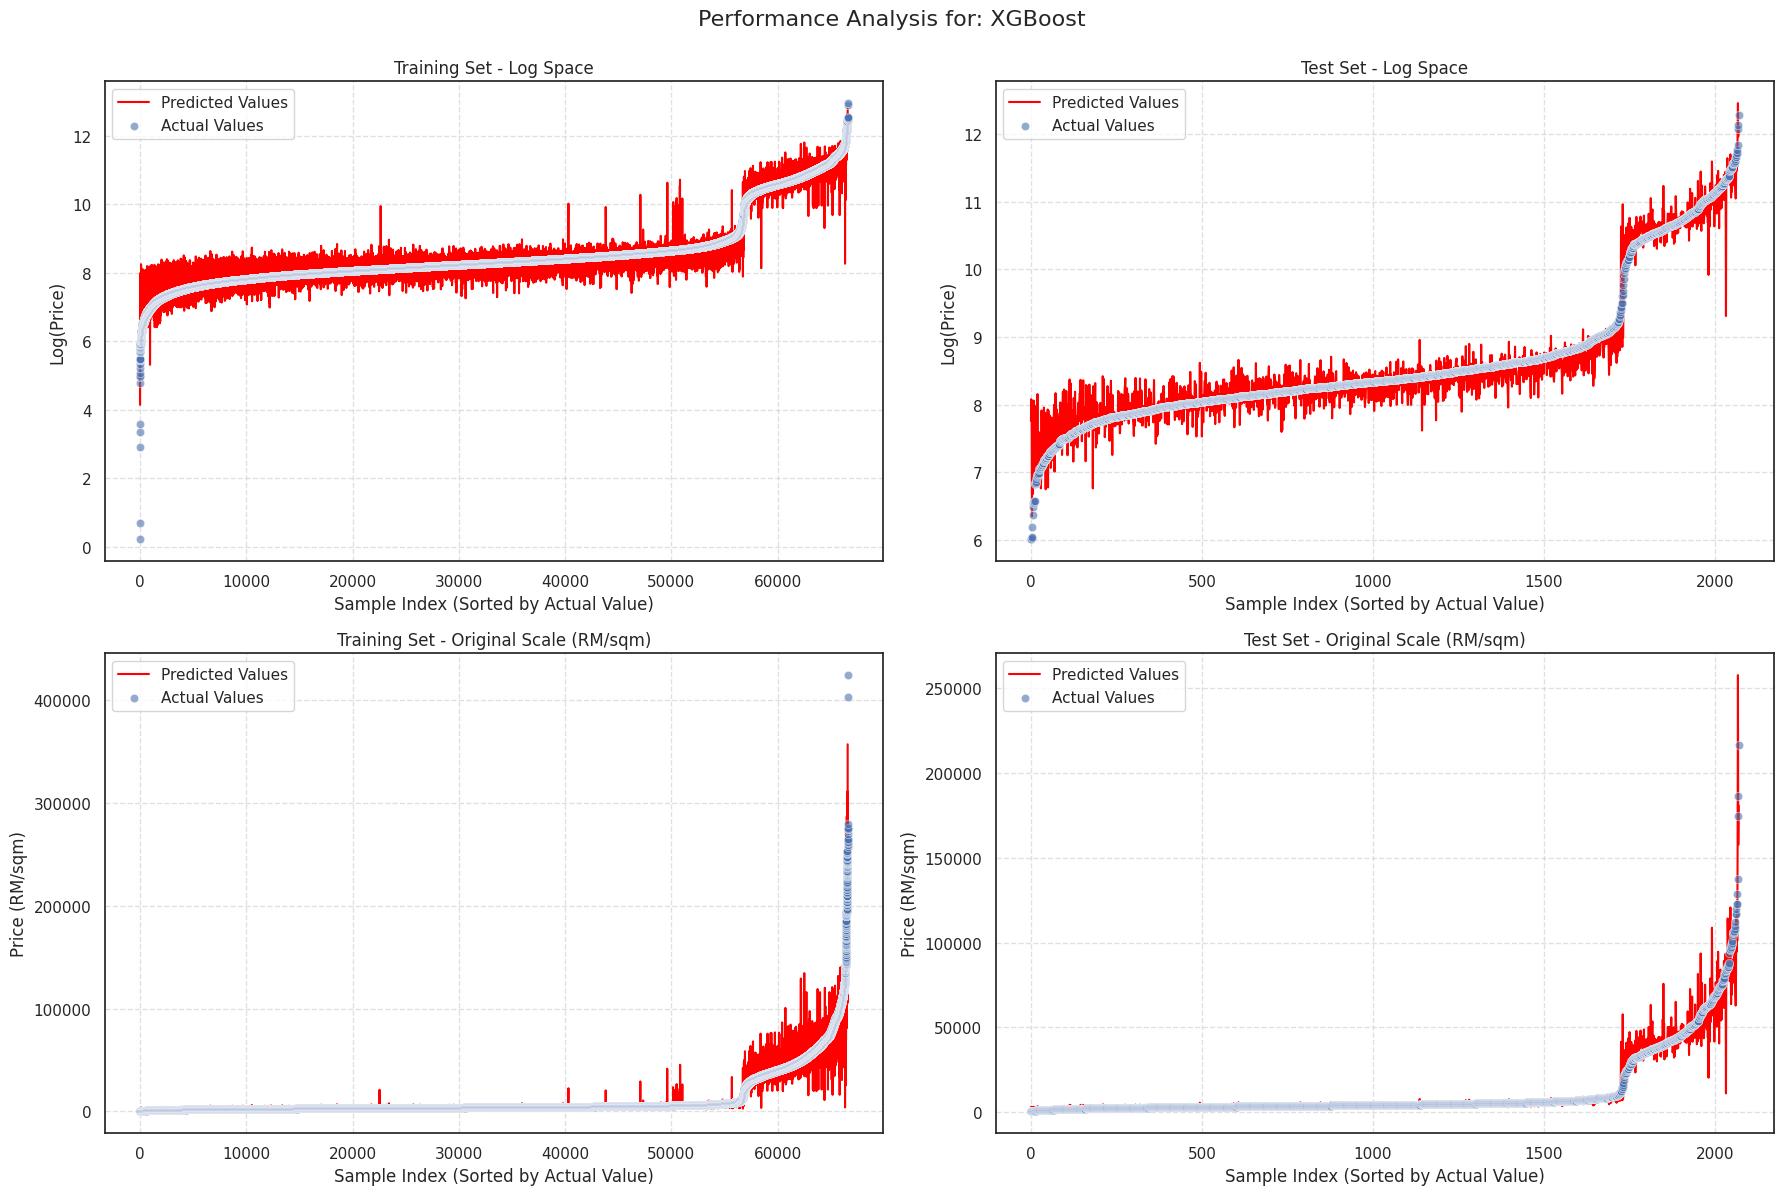

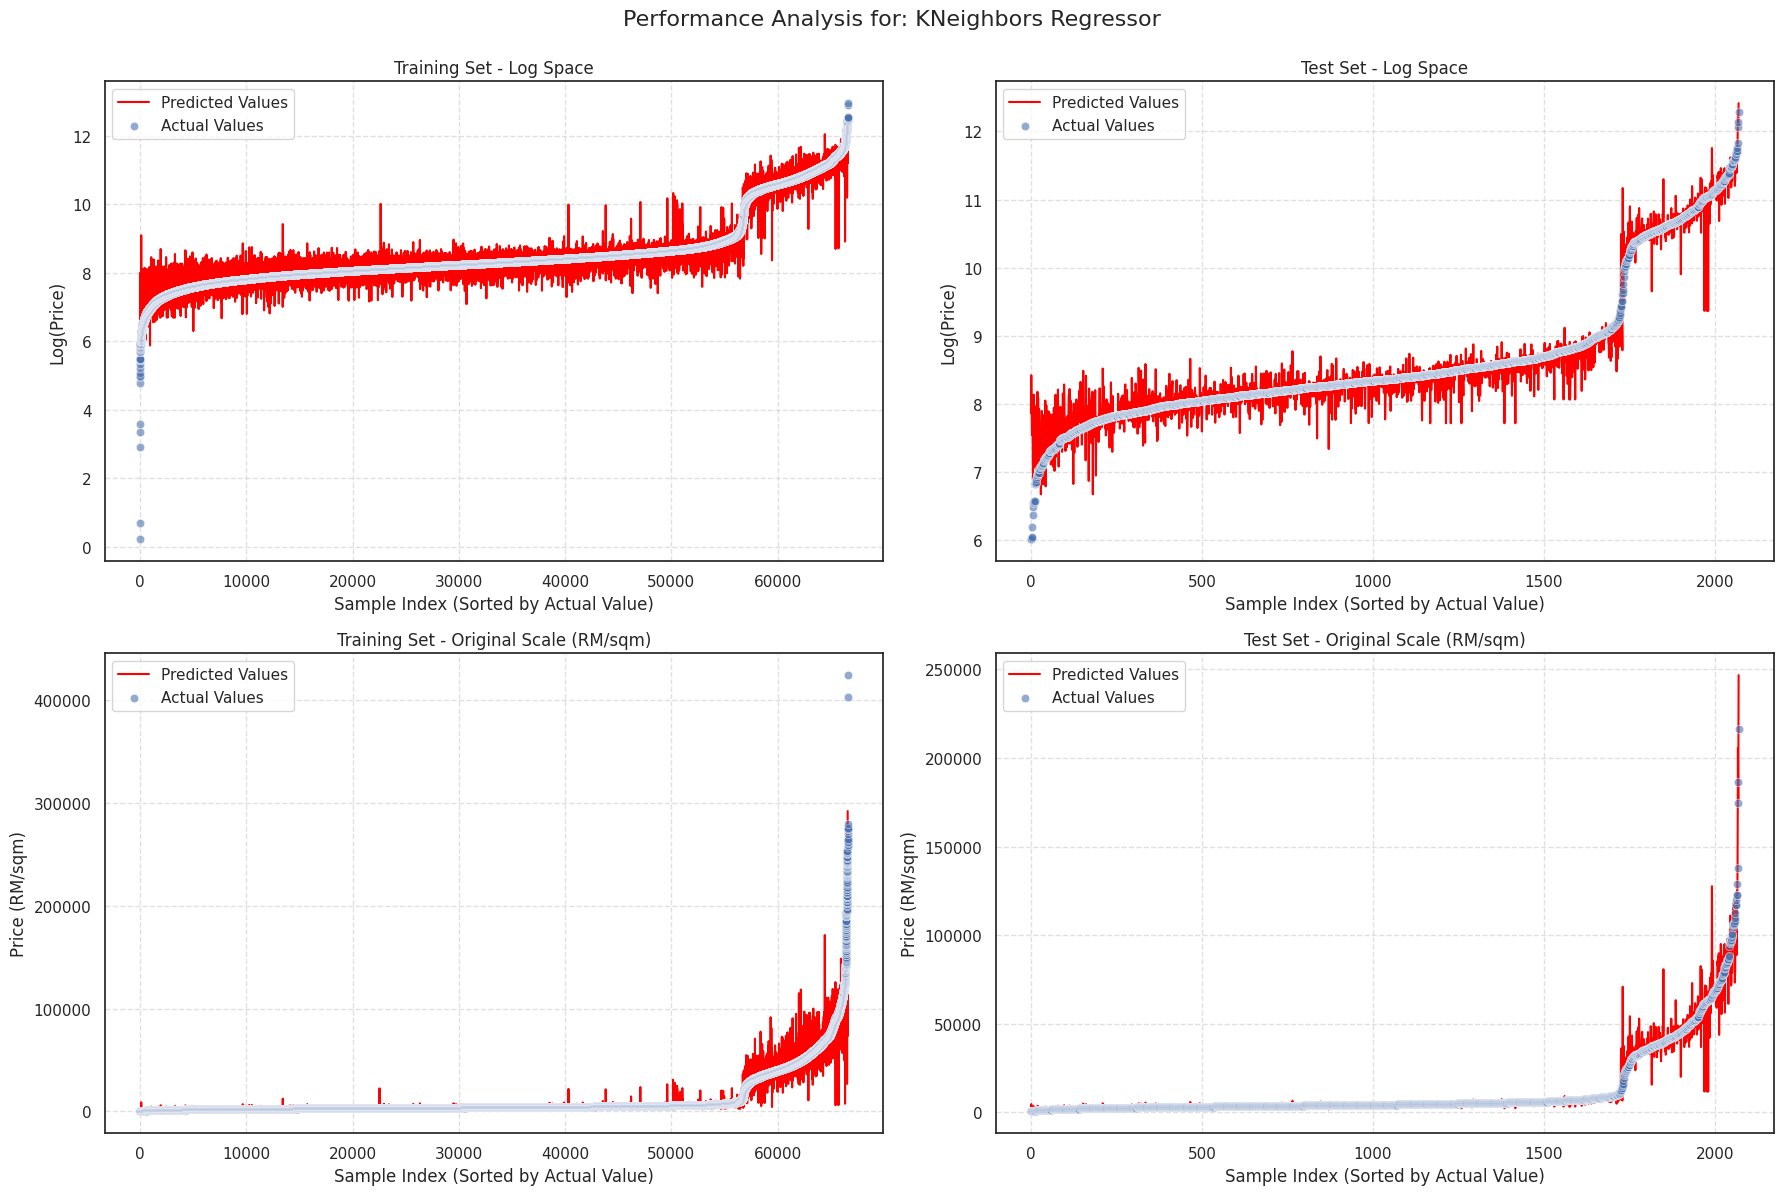

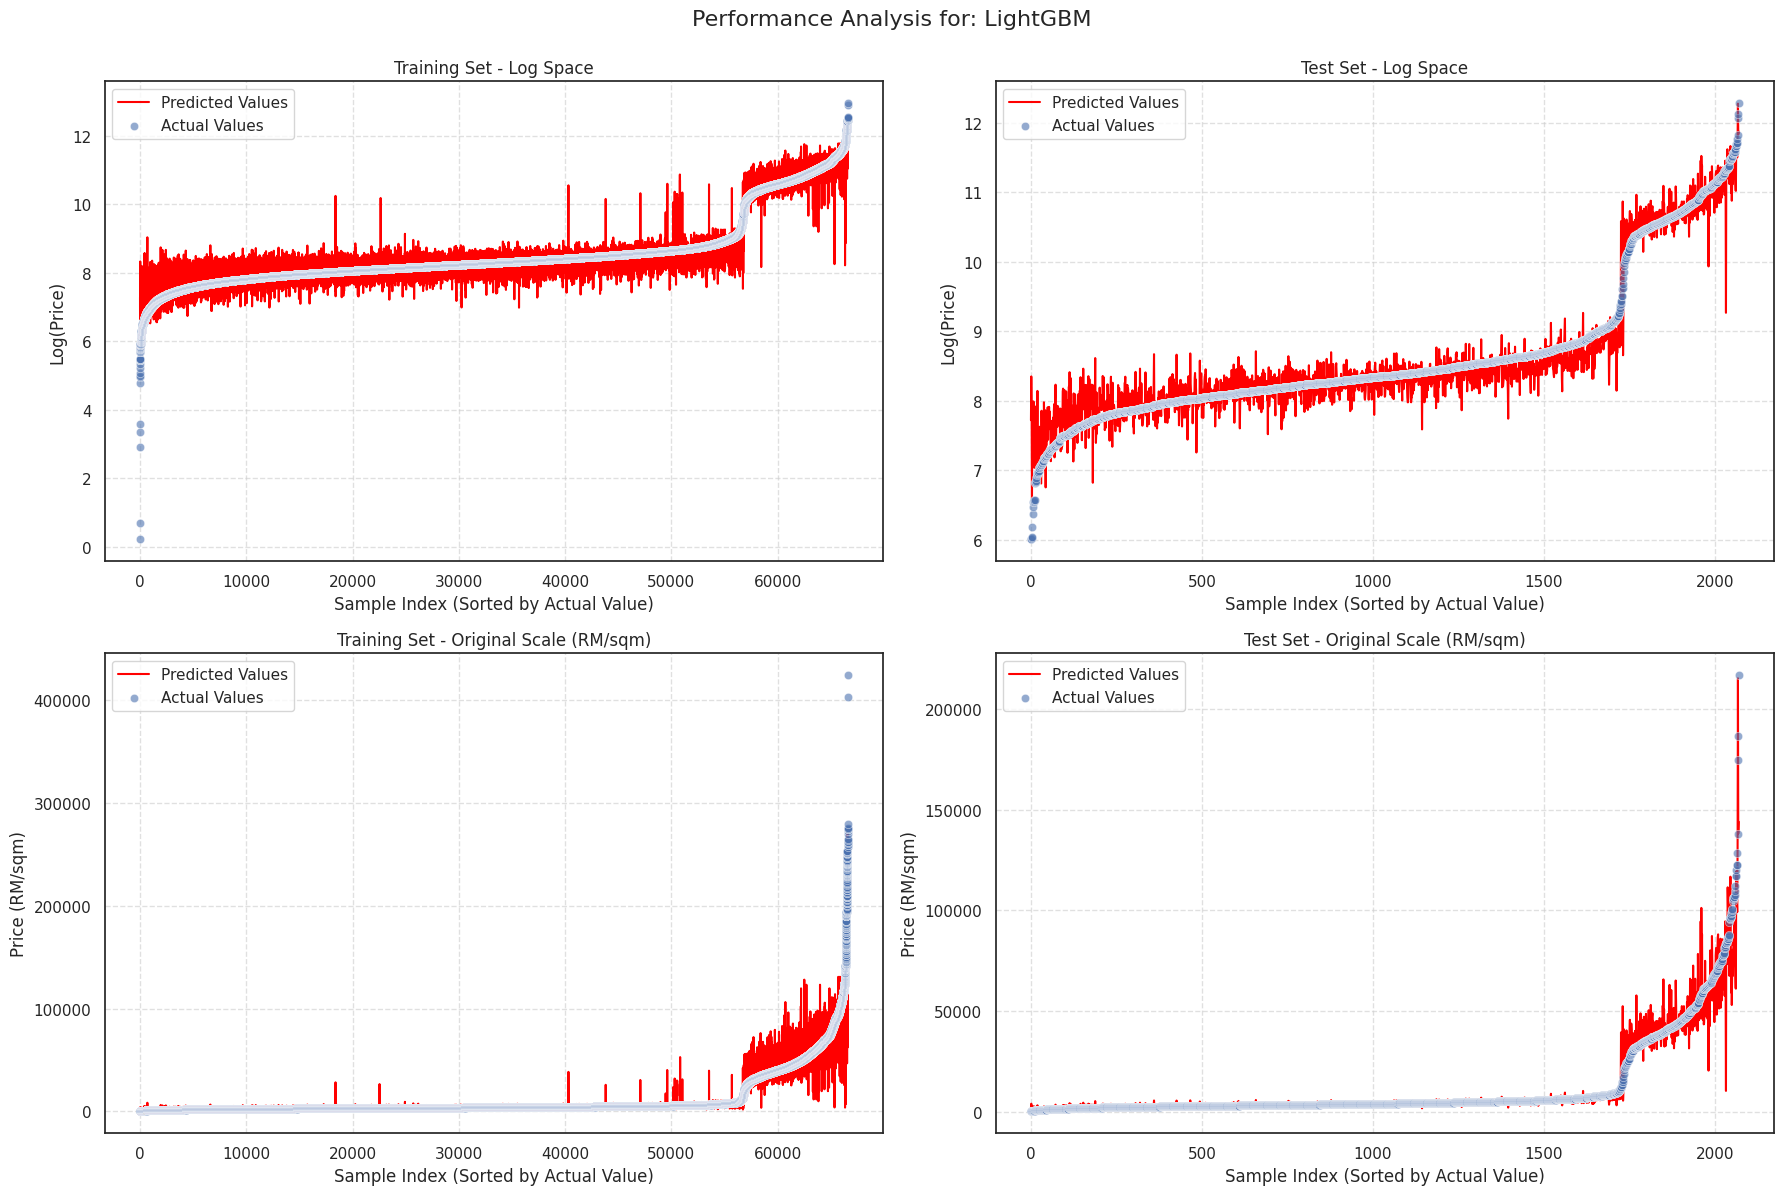

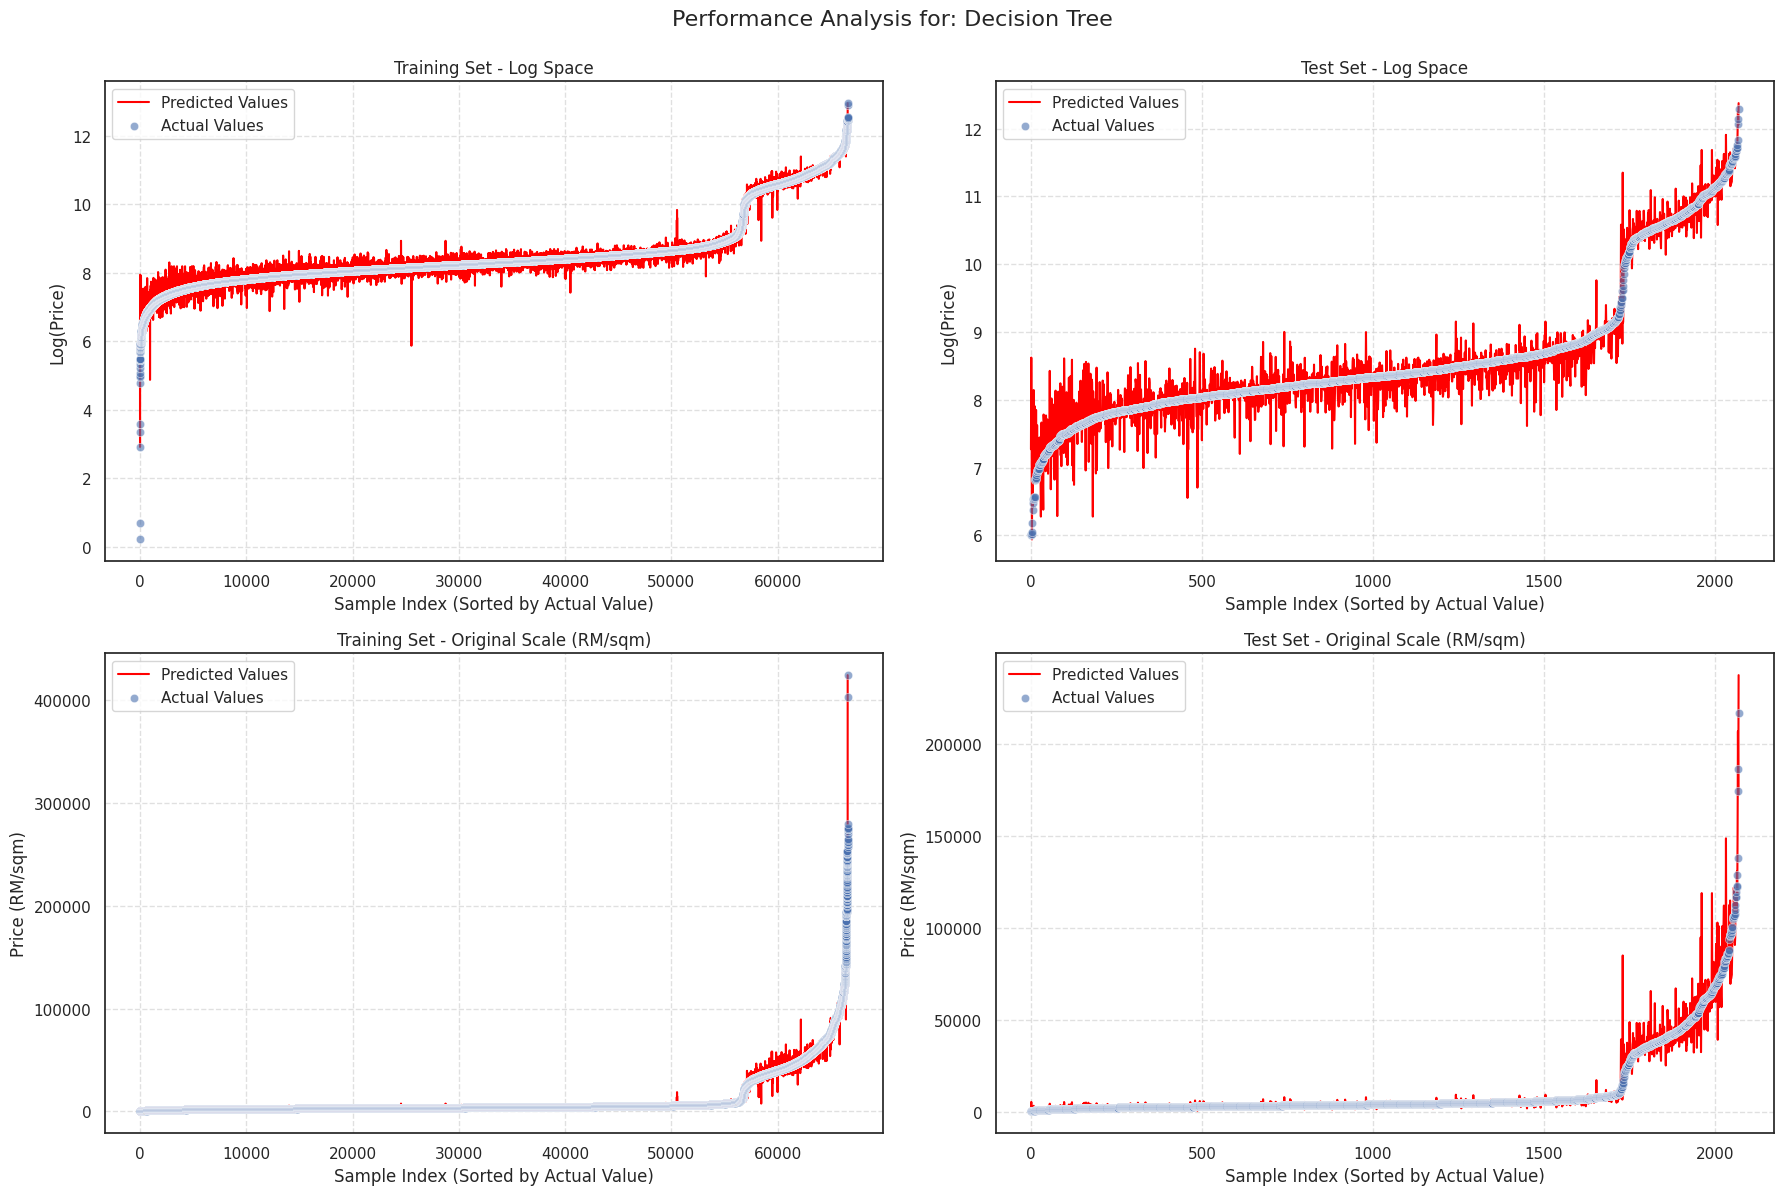

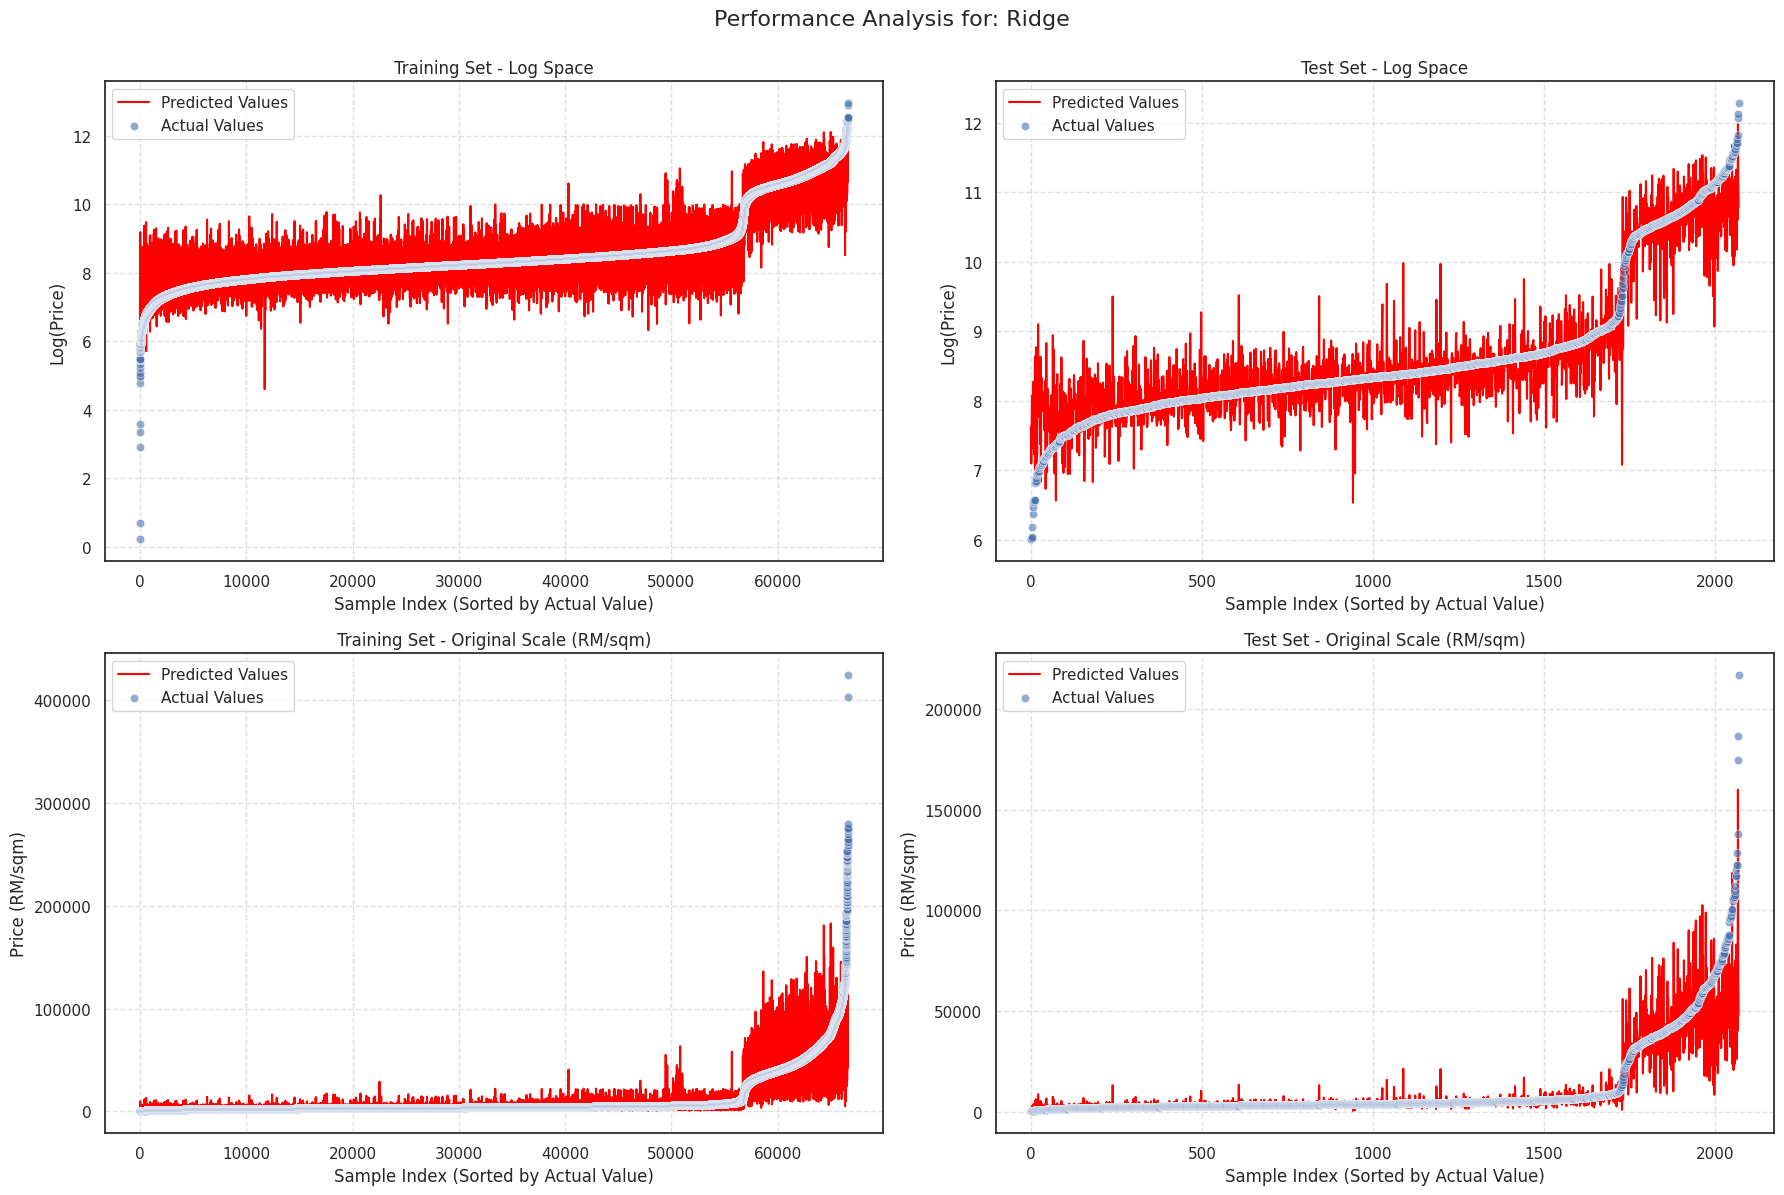

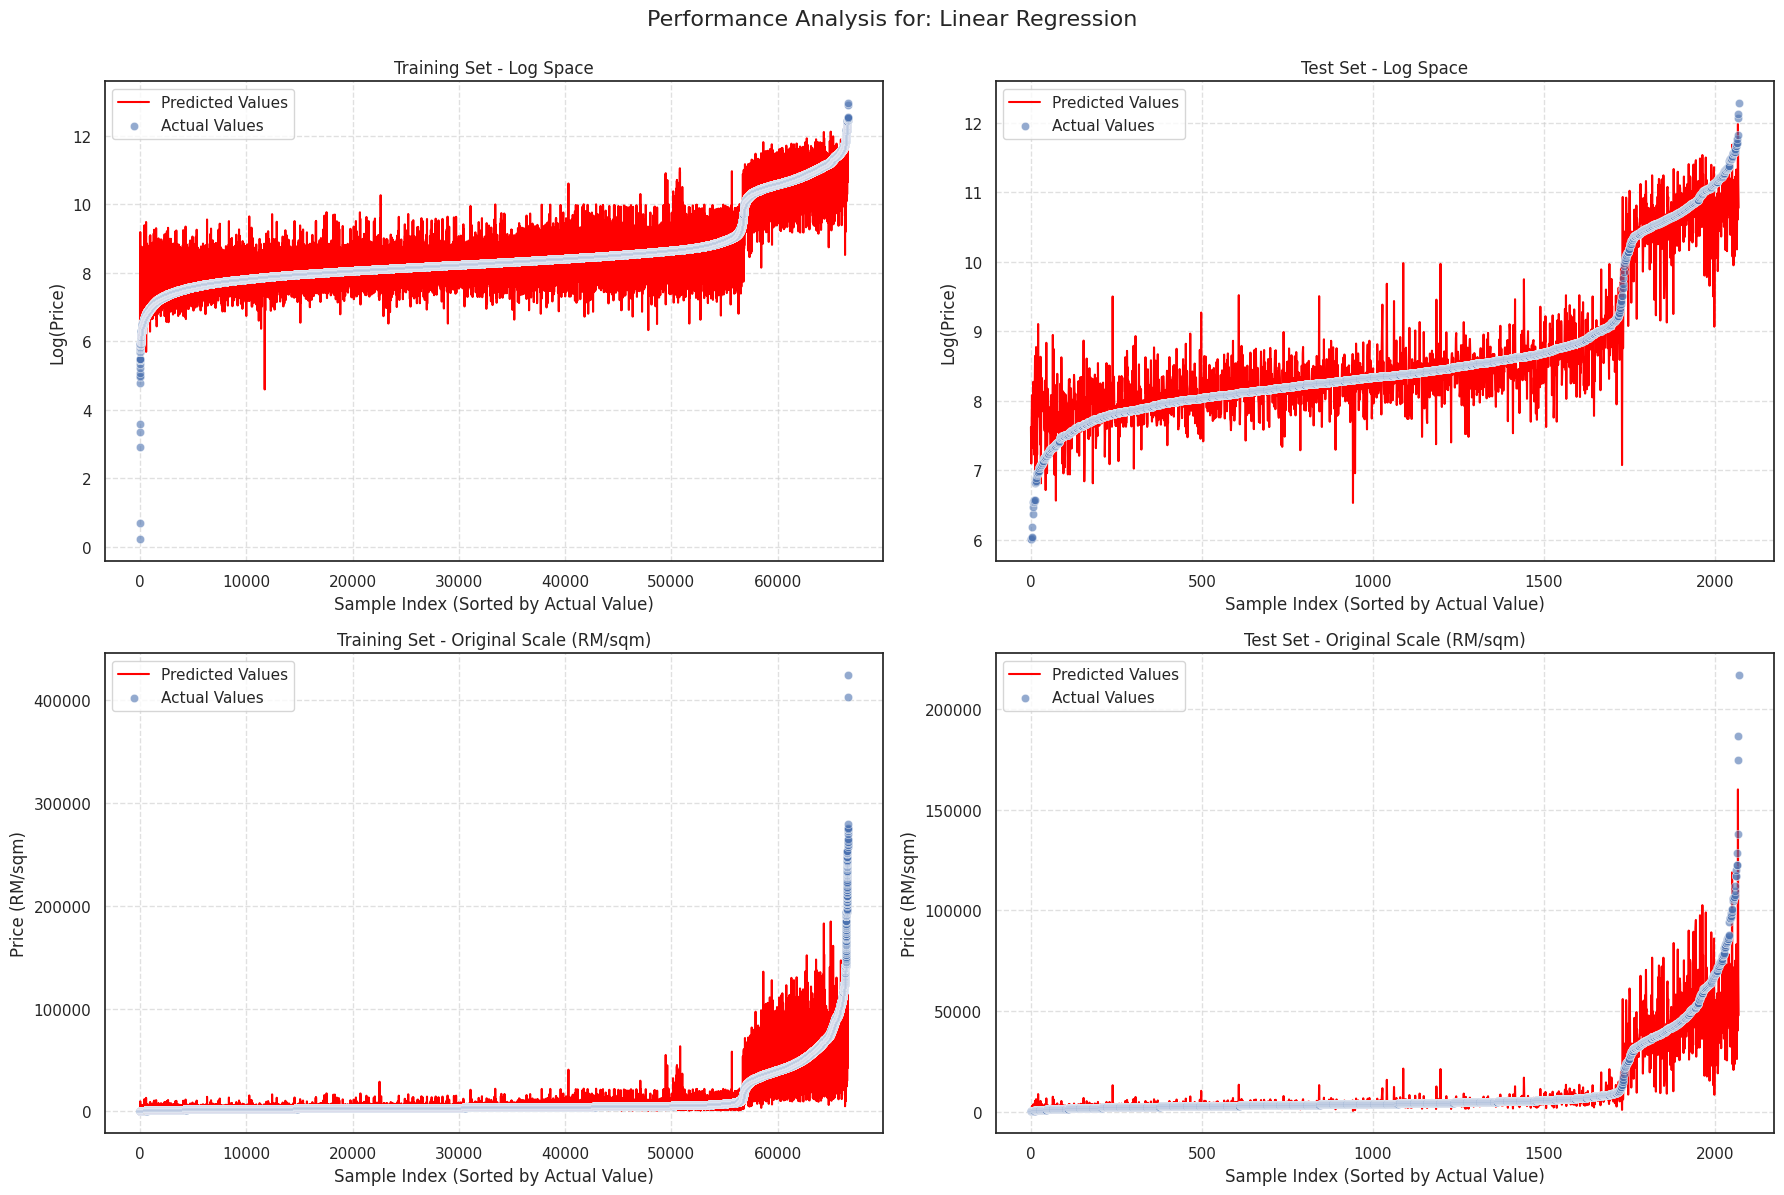

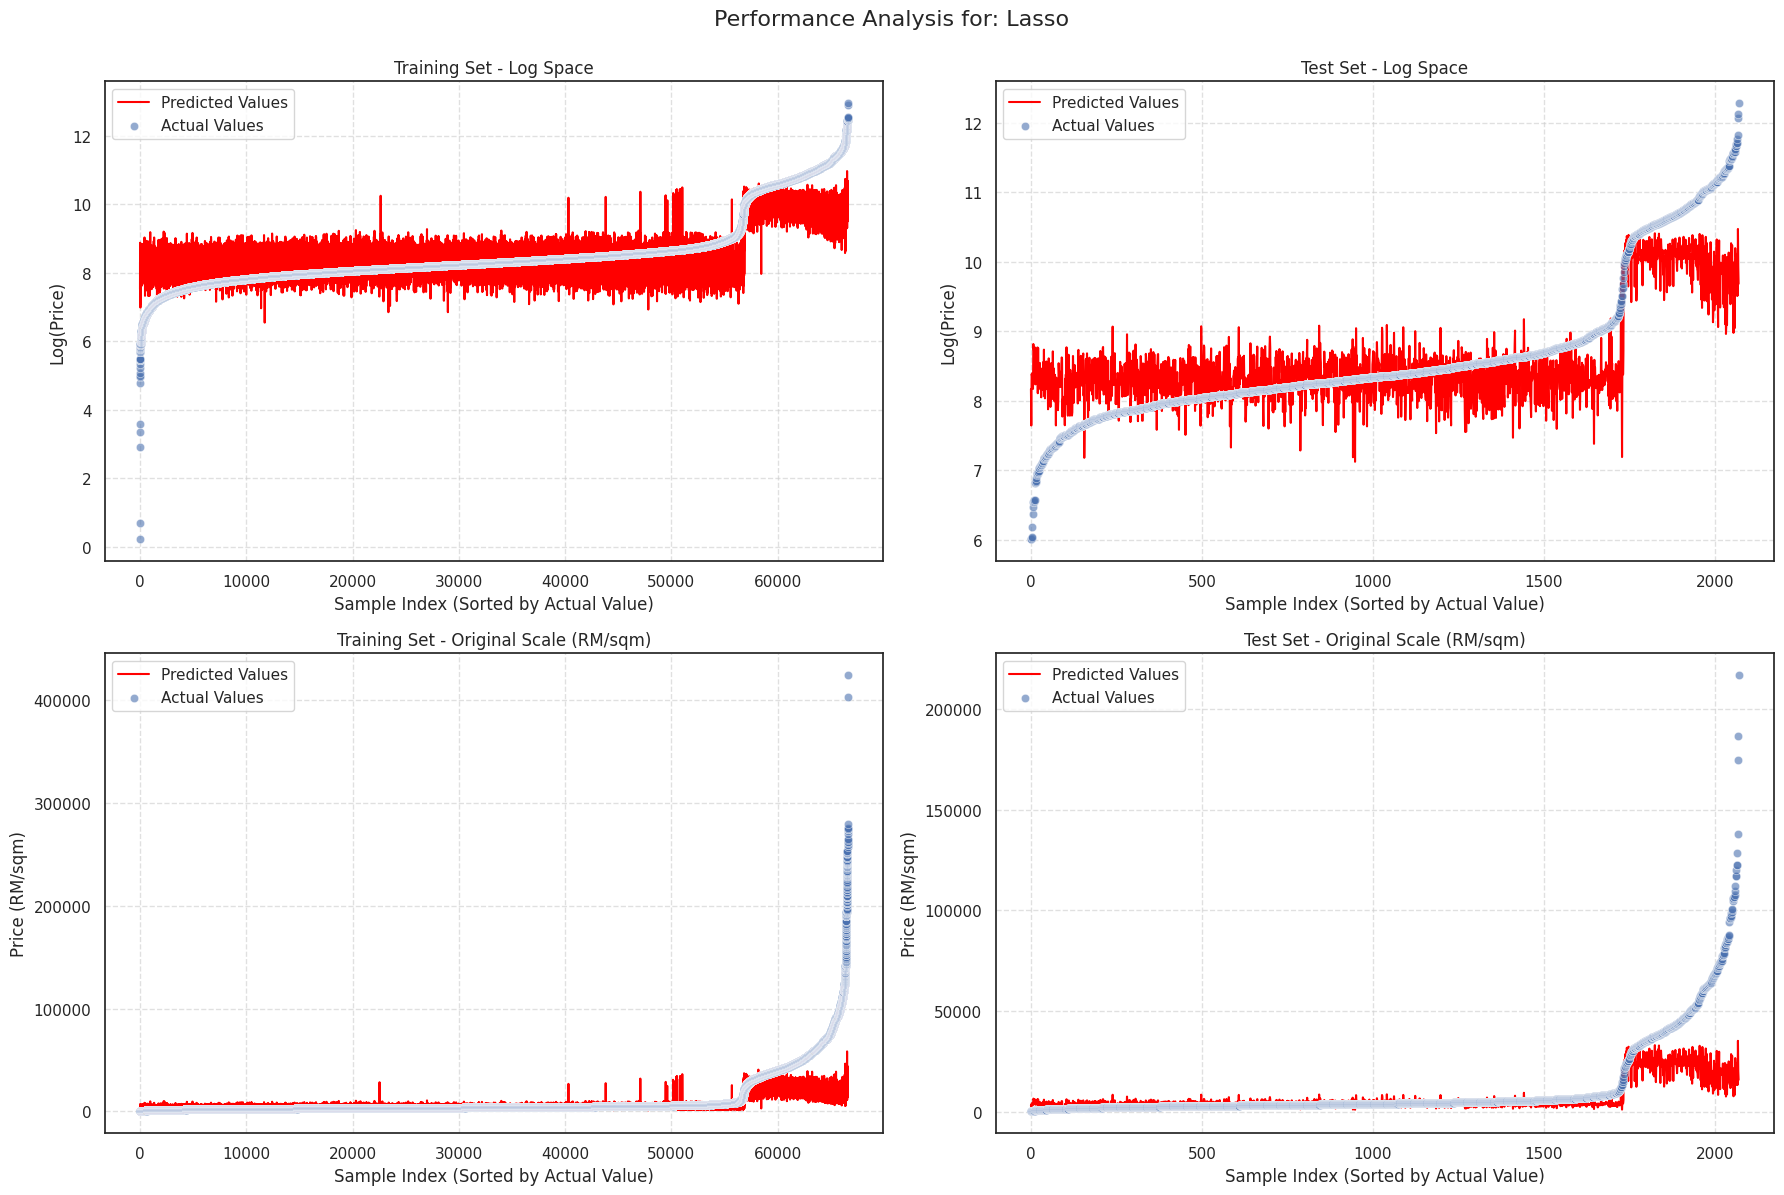

Ranking                 Model  Train_Log R2  CV_Log R2  Test_Log R2  \
0        1         Random Forest          0.99       0.95         0.95   
1        2               XGBoost          0.95       0.94         0.94   
2        3  KNeighbors Regressor          0.97       0.94         0.94   
3        4              LightGBM          0.94       0.94         0.93   
4        5         Decision Tree          0.99       0.93         0.93   
5        6                 Ridge          0.83       0.83         0.82   
6        7     Linear Regression          0.83       0.83         0.82   
7        8                 Lasso          0.60       0.60         0.63   

   Train_Log RMSE  CV_Log RMSE  Test_Log RMSE  Train_Log MAE  CV_Log MAE  \
0            0.11         0.22           0.23           0.07        0.14   
1            0.22         0.25           0.26           0.16        0.17   
2            0.19         0.25           0.27           0.12        0.16   
3            0.25         0.26           0.27           0.18        0.19   
4            0.09         0.28           0.28           0.03        0.17   
5            0.43         0.43           0.44           0.31        0.31   
6            0.43         0.43           0.44           0.31        0.31   
7            0.66         0.66           0.64           0.51        0.51   

   Test_Log MAE  Train_Orig R2  Test_Orig R2  Train_Orig RMSE  Test_Orig RMSE  \
0          0.15           0.99          0.97          2187.11         3905.16   
1          0.18           0.95          0.93          5208.74         5622.75   
2          0.17           0.97          0.95          4089.51         4869.83   
3          0.19           0.92          0.92          6258.67         5914.12   
4          0.19           1.00          0.94           922.40         4983.32   
5          0.32           0.71          0.69         12041.21        11685.75   
6          0.32           0.71          0.69         12041.64        11690.55   
7          0.49           0.33          0.34         18307.94        17134.50   

   Train_Orig MAE  Test_Orig MAE  Train_Orig MAPE  Test_Orig MAPE  
0          611.74        1509.58            12.48           16.32  
1         1730.89        2067.10            24.72           19.43  
2         1209.29        1766.48            20.16           18.65  
3         2030.01        2219.03            30.01           20.69  
4          203.60        1884.34             8.78           19.96  
5         4006.91        4354.95            50.01           35.21  
6         4005.66        4356.04            50.03           35.21  
7         6462.91        6539.39            86.26           51.78

In [15]:
# Combine train + test for maximum training data
X_full = np.vstack([X_train_scaled, X_test_scaled])
y_full_log = pd.concat([y_train_log, y_test_log])
y_full = pd.concat([y_train, y_test])

# TRAIN BEST MODELS ON FULL PRE-2025 DATA
perf_2025, train_models_2025 = train_test_plot(X_full, X_2025_scaled,
                             y_full_log, y_2025_log,
                             y_full, y_2025,
                             cv =10)
perf_2025

# FEATURE IMPORTANCE

✅ Saved: feature_importance.png


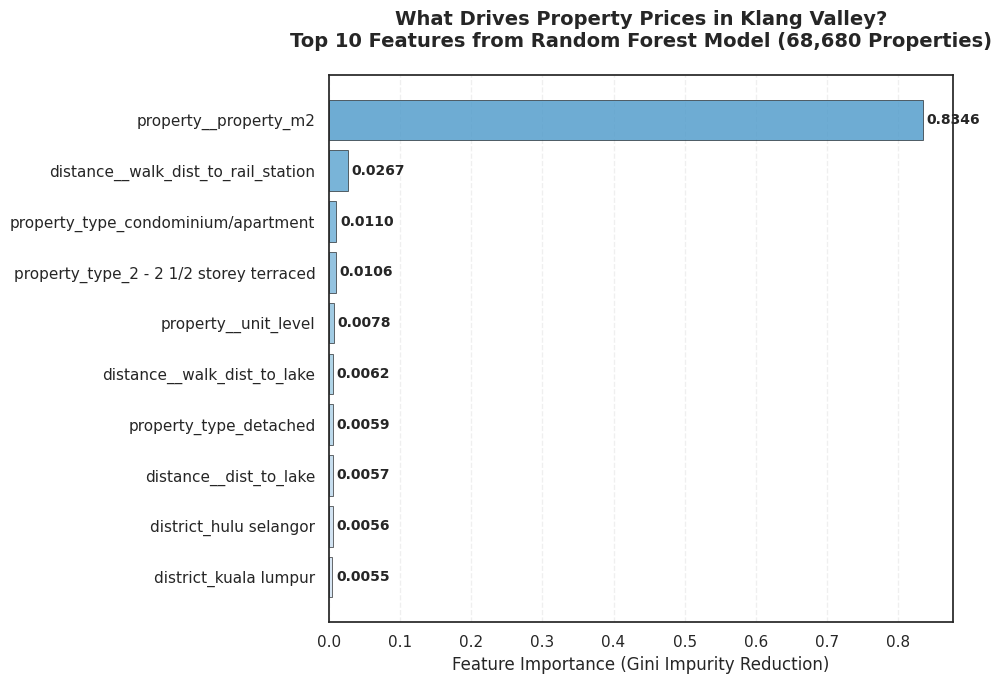

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Extract feature names
continuous_feature_names = preprocessor.get_feature_names_out().tolist()
categorical_feature_names = encoder.get_feature_names_out(categorical_features).tolist()
all_feature_names = continuous_feature_names + categorical_feature_names

# Get the trained model
rf_model = train_models_2025['Random Forest']

# Get feature names from the columns
feature_names = all_feature_names

# Get feature importances
importances = rf_model.feature_importances_

# Create dataframe and sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Get top 10
top10 = importance_df.head(10)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 7))

# Plot bars with gradient color
colors = plt.cm.Blues_r(np.linspace(0.4, 0.8, len(top10)))
bars = ax.barh(range(len(top10)), top10['Importance'], color=colors,
               alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['Feature'], fontsize=11)
ax.set_xlabel('Feature Importance (Gini Impurity Reduction)', fontsize=12)
ax.set_title('What Drives Property Prices in Klang Valley?\nTop 10 Features from Random Forest Model (68,680 Properties)',
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top10['Importance'])):
    ax.text(value + 0.005, bar.get_y() + bar.get_height()/2,
            f'{value:.4f}',
            va='center', fontsize=10, fontweight='bold')

# Add grid
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
#plt.savefig('/content/feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
#print("✅ Saved: feature_importance.png")
plt.show()

# Download
#from google.colab import files
#files.download('/content/feature_importance.png')

# Export Models

In [17]:
# Get the best model from your trained_models dictionary
best_model = train_models_2025['Random Forest']

# Save the model
#with open('production_model_rf_pre2025.pkl', 'wb') as f:
#    pickle.dump(best_model, f)
#print("✅ Random Forest model exported successfully!")

# STEP 2: Export the StandardScaler
#with open('scaler_pre2025.pkl', 'wb') as f:
#    pickle.dump(preprocessor, f)
#print("✅ StandardScaler exported successfully!")

# STEP 3: Create the model_metadata.json File

# Extract Random Forest metrics (convert Series to float)
rf_metrics = perf_2025[perf_2025['Model'] == 'Random Forest'].iloc[0]

metadata = {
    "model_name": "Random Forest Regressor - Klang Valley Property Valuation",
    "model_version": "1.0",
    "model_type": "RandomForestRegressor",
    "framework": "scikit-learn",
    "export_timestamp": datetime.now().isoformat() + "Z",

    "training_data": {
        "total_samples": int(X_full.shape[0]),
        "n_features": int(X_full.shape[1]),
        "target_variable": "price_m2",
        "target_transformation": "log1p",
        "date_range": "Pre-2025 (2023-2024)",
        "geographic_scope": "Klang Valley, Malaysia",
        "data_source": "National Property Information Centre (NAPIC) Malaysia"
    },

    "test_data": {
        "temporal_holdout_samples": int(X_2025.shape[0]),
        "test_date_range": "2025 Q1",
        "validation_strategy": "Strict temporal split (train on pre-2025, test on 2025)"
    },

    "hyperparameters": {
        "n_estimators": int(best_model.n_estimators),
        "max_depth": int(best_model.max_depth) if best_model.max_depth else None,
        "min_samples_split": int(best_model.min_samples_split),
        "min_samples_leaf": int(best_model.min_samples_leaf),
        "max_features": str(best_model.max_features),
        "bootstrap": bool(best_model.bootstrap),
        "random_state": int(best_model.random_state),
        "n_jobs": int(best_model.n_jobs),
        "verbose": int(best_model.verbose),
        "optimization_method": "GridSearchCV with 10-fold cross-validation"
    },

    "performance_metrics": {
        "temporal_validation_2025": {
            "train_log_r2": float(rf_metrics['Train_Log R2']),
            "cv_log_r2": float(rf_metrics['CV_Log R2']),
            "test_log_r2": float(rf_metrics['Test_Log R2']),
            "train_log_rmse": float(rf_metrics['Train_Log RMSE']),
            "cv_log_rmse": float(rf_metrics['CV_Log RMSE']),
            "test_log_rmse": float(rf_metrics['Test_Log RMSE']),
            "train_log_mae": float(rf_metrics['Train_Log MAE']),
            "cv_log_mae": float(rf_metrics['CV_Log MAE']),
            "test_log_mae": float(rf_metrics['Test_Log MAE']),
            "train_orig_r2": float(rf_metrics['Train_Orig R2']),
            "test_orig_r2": float(rf_metrics['Test_Orig R2']),
            "train_orig_rmse": float(rf_metrics['Train_Orig RMSE']),
            "test_orig_rmse": float(rf_metrics['Test_Orig RMSE']),
            "train_orig_mae": float(rf_metrics['Train_Orig MAE']),
            "test_orig_mae": float(rf_metrics['Test_Orig MAE']),
            "train_orig_mape": float(rf_metrics['Train_Orig MAPE']),
            "test_orig_mape": float(rf_metrics['Test_Orig MAPE']),
            "note": "Metrics from 2025 temporal holdout validation"
        },
        "inference_speed": {
            "single_prediction_seconds": 0.02,
            "batch_2k_properties_seconds": 4.2,
            "throughput_predictions_per_second": 476
        }
    },

    "feature_categories": {
        "continuous_geospatial": {
            "count": len(continuous_features),
            "examples": continuous_features
        },
        "property_type_dummies": {
            "count": 11,
            "examples": [
                "property_type_1 - 1 1/2 storey terraced",
                "property_type_2 - 2 1/2 storey semi-detached",
                "property_type_2 - 2 1/2 storey terraced",
                "property_type_cluster house",
                "property_type_condominium/apartment",
                "property_type_detached",
                "property_type_flat",
                "property_type_low-cost flat",
                "property_type_low-cost house",
                "property_type_town house"
            ]
        },
        "district_dummies": {
            "count": 11,
            "examples": [
                "district_hulu langat", "district_hulu selangor", "district_klang",
                "district_kuala langat", "district_kuala lumpur", "district_kuala selangor",
                "district_petaling", "district_putrajaya", "district_sabak bernam",
                "district_sepang"
            ]
        },
        "market_cluster_dummies": {
            "count": 238,
            "note": "Spatial clusters consolidating 18,000+ unique road names into 238 market segments using DBSCAN/K-Means clustering",
            "cluster_prefixes": {
                "GO": "Gombak district clusters",
                "HU": "Hulu Langat/Hulu Selangor clusters",
                "KL": "Kuala Lumpur central clusters",
                "KU": "Kuala Langat/Kuala Selangor clusters",
                "PE": "Petaling district clusters",
                "PU": "Putrajaya clusters",
                "SA": "Sabak Bernam clusters",
                "SE": "Sepang clusters",
                "NOISE": "Outlier properties not assigned to spatial clusters"
            }
        }
    },

    # ALL feature names in exact order
    "feature_names": feature_names,

    "preprocessing": {
        "scaling": {
            "method": "StandardScaler",
            "fitted_on": f"{X_full.shape[0]} pre-2025 training samples",
            "file": "scaler_pre2025.pkl",
            "note": "All continuous features scaled to mean=0, std=1"
        },
        "target_transformation": {
            "method": "log1p (natural log of (price_m2 + 1))",
            "reason": "Handle right-skewed price distribution and reduce impact of luxury outliers",
            "inverse_transform": "expm1 (exp(log_price) - 1)"
        },
        "categorical_encoding": {
            "method": "One-hot encoding",
            "categories": {
                "property_type": 11,
                "district": 11,
                "market_cluster_id": 238
            }
        }
    },

    "limitations": {
        "geographic_scope": "Model trained exclusively on Klang Valley properties. Do not use for other Malaysian regions (Penang, Johor, etc.)",
        "temporal_drift": "Trained on 2023-2024 data. Annual retraining recommended to capture evolving market conditions."
    },

    "deployment_notes": {
        "environment": "Python 3.9+, scikit-learn 1.3.0+, pandas, numpy",
        "error_handling": "Model does not handle NaN values - impute missing data before prediction",
        "scaling_requirement": "MUST apply scaler_pre2025.pkl to all continuous features before prediction",
        "output_format": "Predictions in log-space - apply np.expm1() to convert to RM/m²"
    },

    "alternative_models_evaluated": {
        "XGBoost": {
            "model_type": "XGBRegressor",
            "test_r2": 0.92,
            "test_mape": 19.94,
            "status": "Strong performer but slightly lower R² than Random Forest"
        },
        "LightGBM": {
            "model_type": "LGBMRegressor",
            "test_r2": 0.91,
            "test_mape": 21.03,
            "status": "Good performance, faster training than XGBoost"
        },
        "Decision Tree": {
            "model_type": "DecisionTreeRegressor",
            "test_r2": 0.96,
            "test_mape": 19.89,
            "status": "High R² but prone to overfitting (Train R² = 0.99)"
        },
        "KNeighbors": {
            "model_type": "KNeighborsRegressor",
            "test_r2": 0.94,
            "test_mape": 20.22,
            "status": "Competitive but slower inference on large datasets"
        },
        "Gradient Boosting": {
            "model_type": "GradientBoostingRegressor",
            "test_r2": 0.86,
            "test_mape": 24.56,
            "status": "Lower performance, longer training time"
        },
        "Ridge": {
            "model_type": "Ridge",
            "test_r2": 0.67,
            "test_mape": 36.03,
            "status": "Linear assumptions fail for non-linear location effects"
        }
    },

    "citation": {
        "author": "Phan, Anh Duc Duy",
        "title": "Klang Valley Property Price Prediction: Geospatial Machine Learning Model",
        "year": 2025,
        "publisher": "GitHub",
        "url": "https://github.com/anhpdd/ml-property-valuation-klang-valley"
    }
}

# Save metadata to JSON
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Model metadata JSON exported successfully!")

# STEP 4: Download All Files from Colab
print("\n📥 Downloading files to local machine...")

#files.download('production_model_rf_pre2025.pkl')
#files.download('scaler_pre2025.pkl')
files.download('model_metadata.json')

✅ Model metadata JSON exported successfully!

📥 Downloading files to local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>